## **ABCDEats Company - Customer Segmentation**

This is notebook 3- Where we will evaluate the one-time customers only.

## **Group Members:**

* **Guilherme Goudinho**- 20211552
* **Maria Inês Assunção**- 20211605
* **Osmáiny Raimundo**- e20191506
* **Vinincius Lallo**- 20211682

<a id = "toc"></a>
## Table of Contents

1. [Imports](#Imports)
    
2. [One-Time Customers](#One-Time-Customers) <br>
    1. [Univariate Analysis](##Univariate-Analysis) <br>
    2. [Bivariate Analysis](##Bivariate-Analysis) <br>



### **1. Imports** <a id="Imports" class="anchor"></a>
[Back to ToC](#toc)<br>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Standard libraries
import os
from itertools import product
from math import ceil

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Statistical analysis
from scipy.stats import chi2_contingency
import scipy.stats as stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from PIL import Image

# IPython display utilities
from IPython.display import display

# Data profiling
from ydata_profiling import ProfileReport

# Inline plot settings
%config InlineBackend.figure_format = 'retina'

# Seaborn settings
sns.set()

# Display all columns in pandas
pd.set_option('display.max_columns', None)

In [2]:
# Auxiliary Function to Calculate bins for histograms based on Sturges' rule
def number_bins_sturges(data):
    '''
    Calculates the number of bins based on the number of data points, using Sturges' rule
    Sturges' rule: k = log2(n) + 1

    Requires: The dataset for which the number of bins is to be calculated.
    Ensures: 
        - The returned value is a positive integer representing the number of bins.
        - The number of bins increases logarithmically as the dataset size increases.
    '''
    
    n = len(data)
    bins = np.ceil(np.log2(n) + 1) # np.log2 computes the base-2 logarithm of n, and np.ceil rounds the result up to the next whole number.
    return int(bins)

#Defining the colors for our graphs
colors = {
    "R": "#F5979D", #light red
    "BL": "#0a9ea3", #cyan blue
    "BR": "#4F323D", #brown
    "B": "#9cc5d9",  #light blue
    "G": "#099c52",  #spring green
    "Y": "#d69231",   #Yellow
    "M": "#960b50",   # some kind of pink
    "P": "#6947ad" ,   # Purple
    "PR": "#ad474c"  #Weird red
}

def show_missing(data):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    for item in data.columns:
        variables.append(item)
        dtypes.append(data[item].dtype)
        count.append(len(data[item]))
        unique.append(len(data[item].unique()))
        missing.append(data[item].isna().sum())
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    })
    return output

### **2. Loading our Dataset**

In [3]:
food_df=pd.read_csv("../Data/food_df_dataset.csv") # Importing our dataset into a variable "food_df" with imputed missing values

__**Setting our Index Column**__

In [4]:
food_df = food_df.set_index('customer_id')

In [5]:
food_df['customer_region'].dtype

dtype('int64')

> This is wrong, probably as a consequence of the data exporting, so we need to turn <code>customer_region</code> back into 'object'.

In [6]:
food_df['customer_region'] = food_df['customer_region'].astype('object') # fixed

> We imputed our <b>Missing Values</b> in the previous notebook and exported the dataset with these treated.
> - <code>customer_age</code>: Imputed with the mean. (After conducting analysis)
> - <code>first_order</code>: Imputed with '0' as these corresponded to customers whose first_order was on the same day as last_order (day 0).
> - <code>HR_0</code>: Imputed with the discrepancy between total_order by DOW and by HR.

In [7]:
columns_with_missing = food_df.isna().sum()[food_df.isna().sum() > 0].count()
print(f"There are {columns_with_missing} columns with more than 0 missing values.")

There are 0 columns with more than 0 missing values.


In [8]:
food_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent'],
      dtype='object')

### **3. Separating Our Data**

> We will drop the following columns as they were previously engineered to be represented by aggregations, described in our EDA and initial preprocessing notebook (part 1).

In [9]:
columns_to_drop = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 
                   'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 
                   'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23',
                   'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 
                   'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                   'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 
                   'CUI_Thai']
food_df = food_df.drop(columns=columns_to_drop)
show_missing(food_df)

,variable,dtype,count,unique,missing
0,customer_region,object,31737,3,0
1,customer_age,int64,31737,66,0
2,vendor_count,int64,31737,36,0
3,product_count,int64,31737,92,0
4,is_chain,int64,31737,60,0
5,first_order,int64,31737,91,0
6,last_order,int64,31737,91,0
7,last_promo,object,31737,4,0
8,payment_method,object,31737,3,0
9,CUI_Healthy,float64,31737,1285,0


> After conducting our analysis on the box plots for each of our numerical variables, we concluded that our one-time customers were probably creating a bias in our data. <br>
> For this reason, we decided to separate this type of customer and perform a separate analysis. The rest of our data will represent the behavior of the customers we are trying to segment.<br>
> We believe this will highly influence our outlier percentages, lowering them and allow us to retain as much information as possible. <br>

> This notebook will address the <b>One-Time Customers</b>.

In [10]:
one_time_customers_df = food_df[food_df['total_orders'] == 1]
food_df = food_df[food_df['total_orders'] > 1]
print(f"One-time customers: {one_time_customers_df.shape[0]} records")
print(f"Remaining customers: {food_df.shape[0]} records")

One-time customers: 6908 records
Remaining customers: 24829 records


> We identified <b>6908</b> records where customers only made 1 purchase. <br>
> These represent roughly 22% of our data. <br>

## **One-Time Customers**

In [11]:
show_missing(one_time_customers_df)

,variable,dtype,count,unique,missing
0,customer_region,object,6908,3,0
1,customer_age,int64,6908,58,0
2,vendor_count,int64,6908,1,0
3,product_count,int64,6908,6,0
4,is_chain,int64,6908,2,0
5,first_order,int64,6908,91,0
6,last_order,int64,6908,91,0
7,last_promo,object,6908,4,0
8,payment_method,object,6908,3,0
9,CUI_Healthy,float64,6908,141,0


In [12]:
numerical_columns = one_time_customers_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = one_time_customers_df.select_dtypes(include=['object', 'O']).columns

__**Data Statistics for One-Time Customers**__

In [13]:
one_time_customers_df.describe().round(2)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_Healthy,CUI_OTHER,CUI_Street Food / Snacks,total_orders,midday_orders,evening_orders,late_night_orders,Weekend,Weekday,Western_Cuisine,Asian_Cuisine,Desserts_Beverages,total_spent
count,6908.00,6908.0,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.0,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00
mean,27.43,1.0,1.38,0.60,46.12,46.17,0.24,0.90,2.32,1.0,0.40,0.42,0.18,0.54,0.46,2.81,6.45,1.45,14.18
std,7.11,0.0,0.62,0.49,26.49,26.51,2.12,3.66,9.07,0.0,0.49,0.49,0.38,0.50,0.50,6.05,10.03,5.44,11.12
min,15.00,1.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37
25%,22.00,1.0,1.00,0.00,23.00,23.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.09
50%,26.00,1.0,1.00,1.00,47.00,47.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,11.75
75%,31.00,1.0,2.00,1.00,69.00,69.00,0.00,0.00,0.00,1.0,1.00,1.00,0.00,1.00,1.00,1.99,11.45,0.00,18.69
max,77.00,1.0,6.00,1.00,90.00,90.00,43.33,78.94,104.32,1.0,1.00,1.00,1.00,1.00,1.00,55.37,91.16,73.02,104.32


> - The average <code>customer_age</code> is still 27y.
> - On average, customers who only made one order, got about 1.38 products.
> - 75% of the one-time customers, did it within the first 2 months and some spare time.
> - Amounts spent by <code>CUI Aggregations</code> is relatively low.
> - One-time customers spent the most on <code>Asian_Cuisine</code> followed by <code>Western_Cuisine</code>, with 6.45€ and 2.81€ respectively.
> - There are more orders during the midday or the evening. Also weekends have more orders.
> - On average, a one-time customer spends 14.18€ ordering out. The max for <code>total_spent</code> is 104.32€ which is surprising for 1 order.

Customer region

In [79]:
one_time_customers_df['customer_region'].value_counts()

customer_region
8000    2616
4000    2283
2000    2009
Name: count, dtype: int64

### Univariate Analsysis

    Time of Day

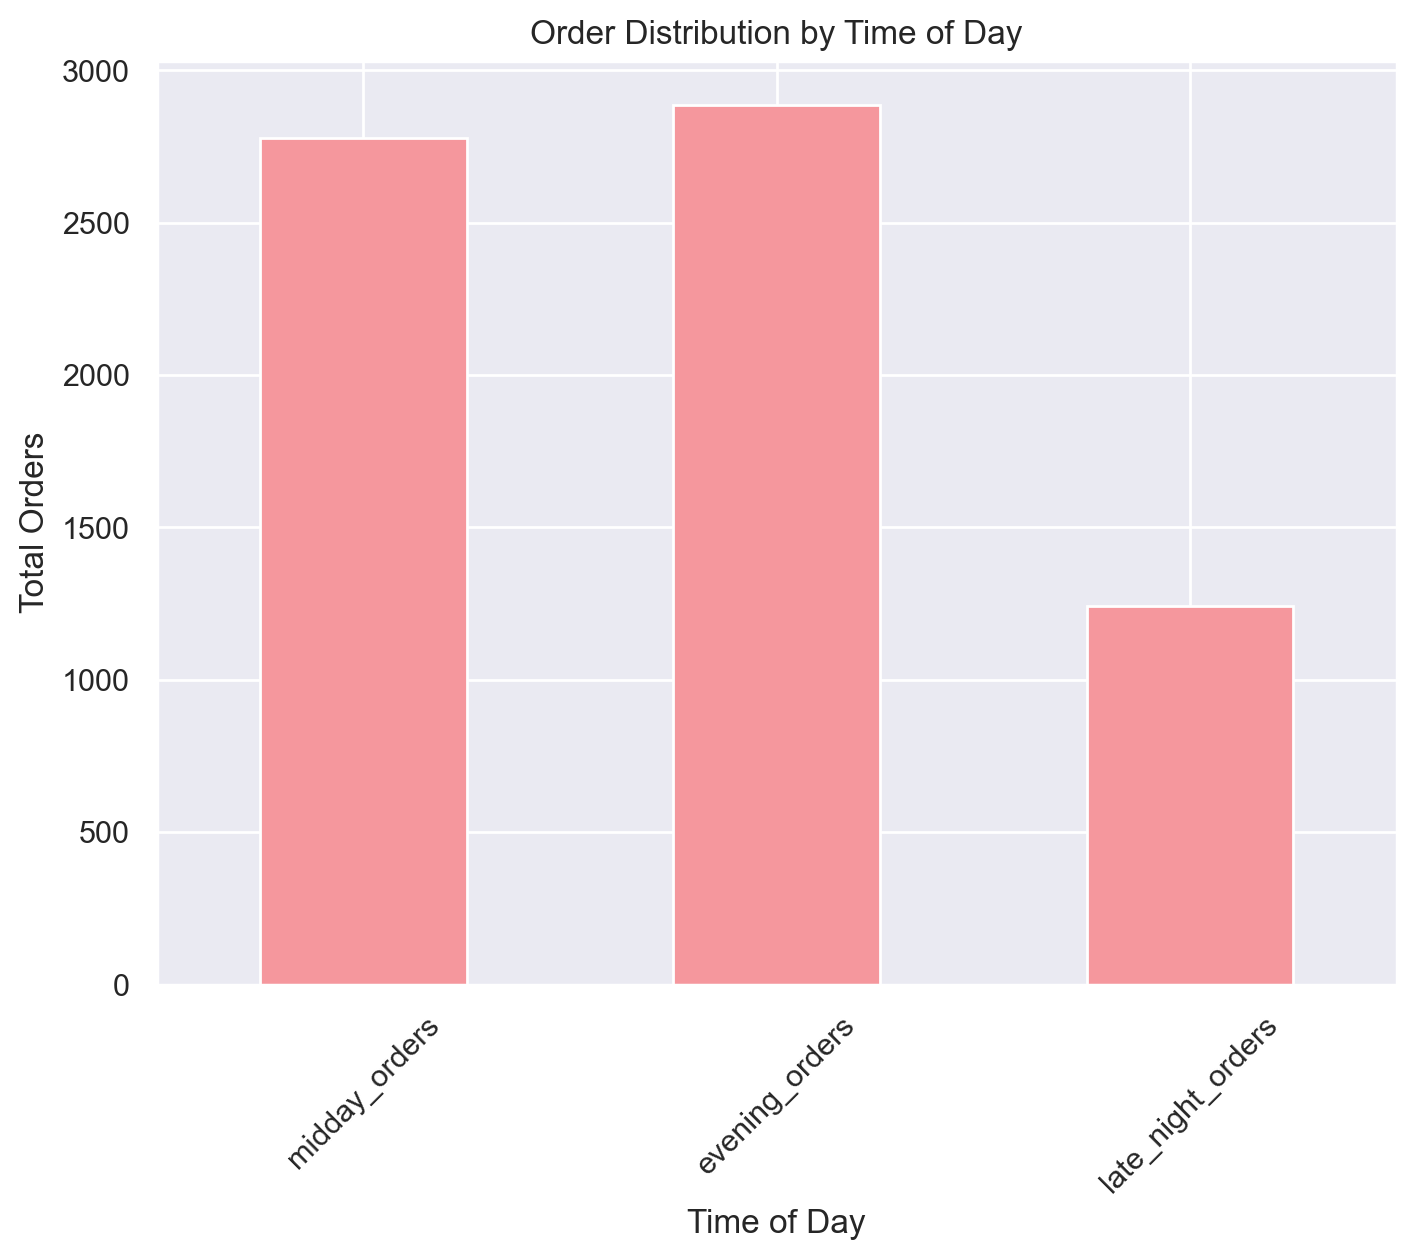

In [57]:
# Creating a bar chart of the orders per time of the day
time_of_day_columns = ['midday_orders', 'evening_orders', 'late_night_orders']

plt.figure(figsize=(8, 6))
one_time_customers_df[time_of_day_columns].sum().plot(kind='bar', color=colors["R"])
plt.title('Order Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.show()

MOst of the orders are done during the midday and evening, with the evening orders slightly higher.

    Cuisines 

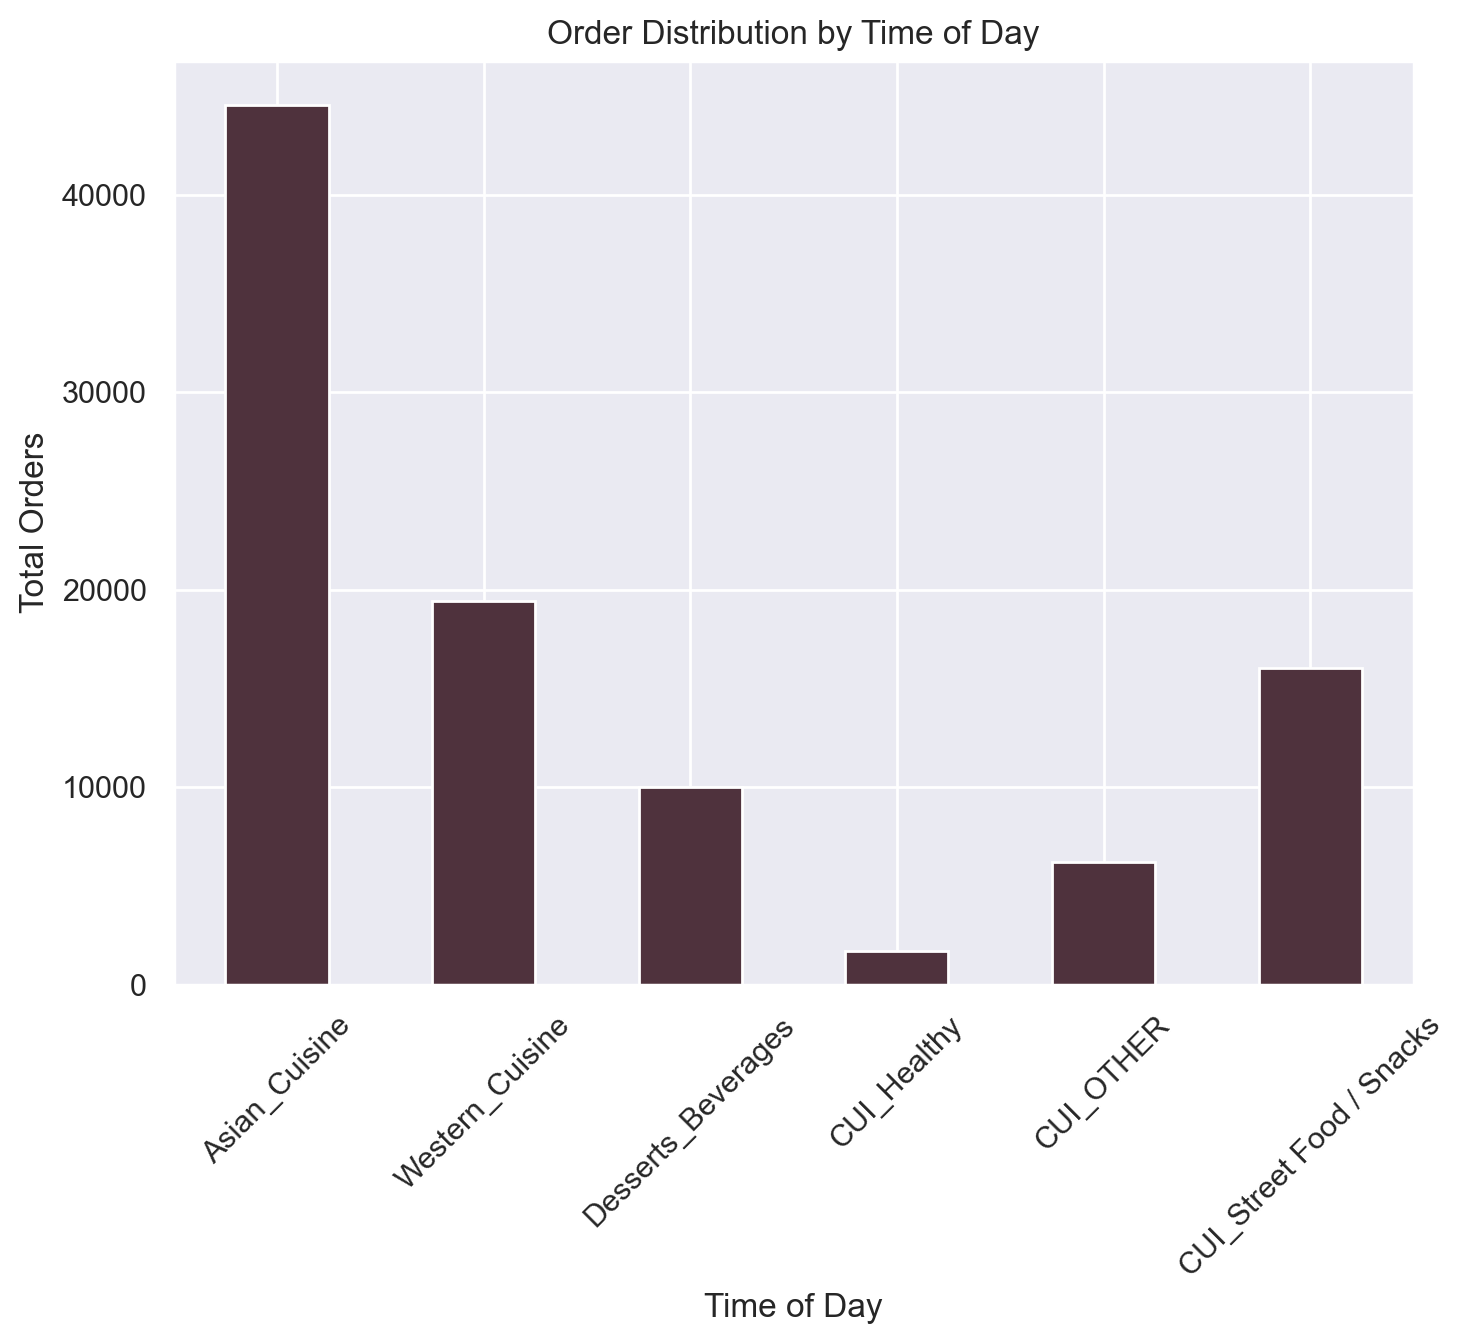

In [58]:
# Creating a bar chart of the orders per cuisine aggregation
cuisine_columns = ['Asian_Cuisine', 'Western_Cuisine', 'Desserts_Beverages', 'CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks']

plt.figure(figsize=(8, 6))
one_time_customers_df[cuisine_columns].sum().plot(kind='bar', color=[colors["BR"]])
plt.title('Order Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.show()

The Asian cuisine is the cuisine with the most orders, with over 4000 orders.

    Last promo

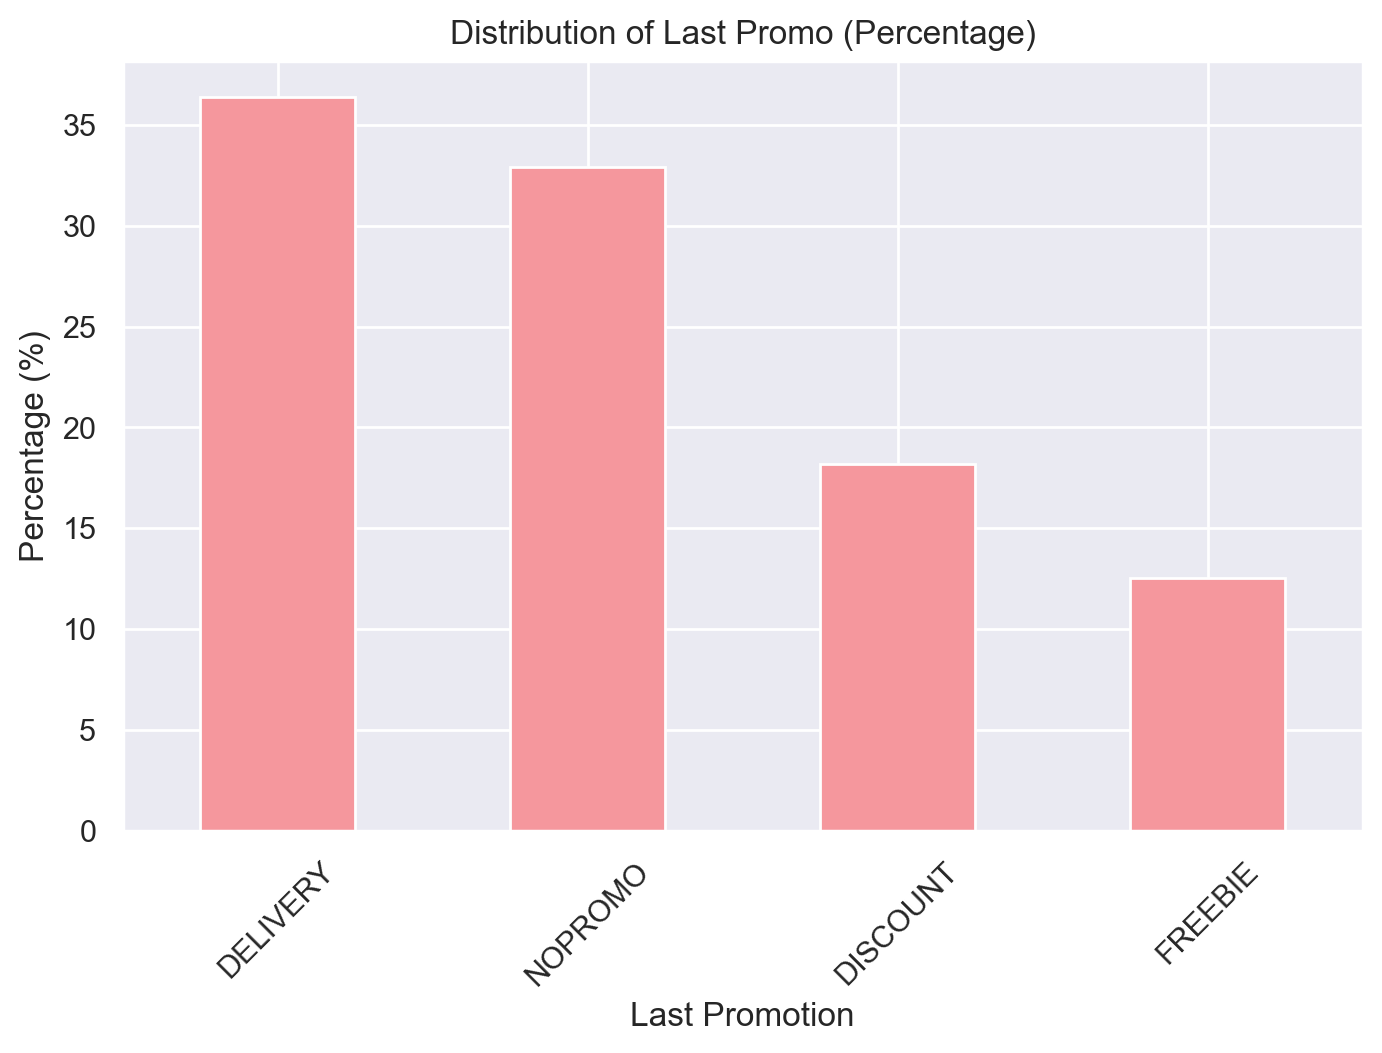

In [65]:
plt.figure(figsize=(8, 5))

# Calculate percentage for each payment method
last_promo_percentage = one_time_customers_df['last_promo'].value_counts(normalize=True) * 100

# Plot the percentages
last_promo_percentage.plot(kind='bar', color=colors["R"])

#Tittles
plt.title('Distribution of Last Promo (Percentage)')
plt.xlabel('Last Promotion')
plt.ylabel('Percentage (%)')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.show()

Over 35% of the orders are done under "DELIVERY" type of promotion, for one time customers

### Multivariate Analysis

##### **Customer Region**

In [24]:
one_time_customers_df['customer_region'].value_counts()

customer_region
8000    2616
4000    2283
2000    2009
Name: count, dtype: int64

The distribution of orders per region, seem even, with region 8000 having the highest entries.

In [25]:
one_time_customers_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent'],
      dtype='object')

    Customer Region by Time of the Day

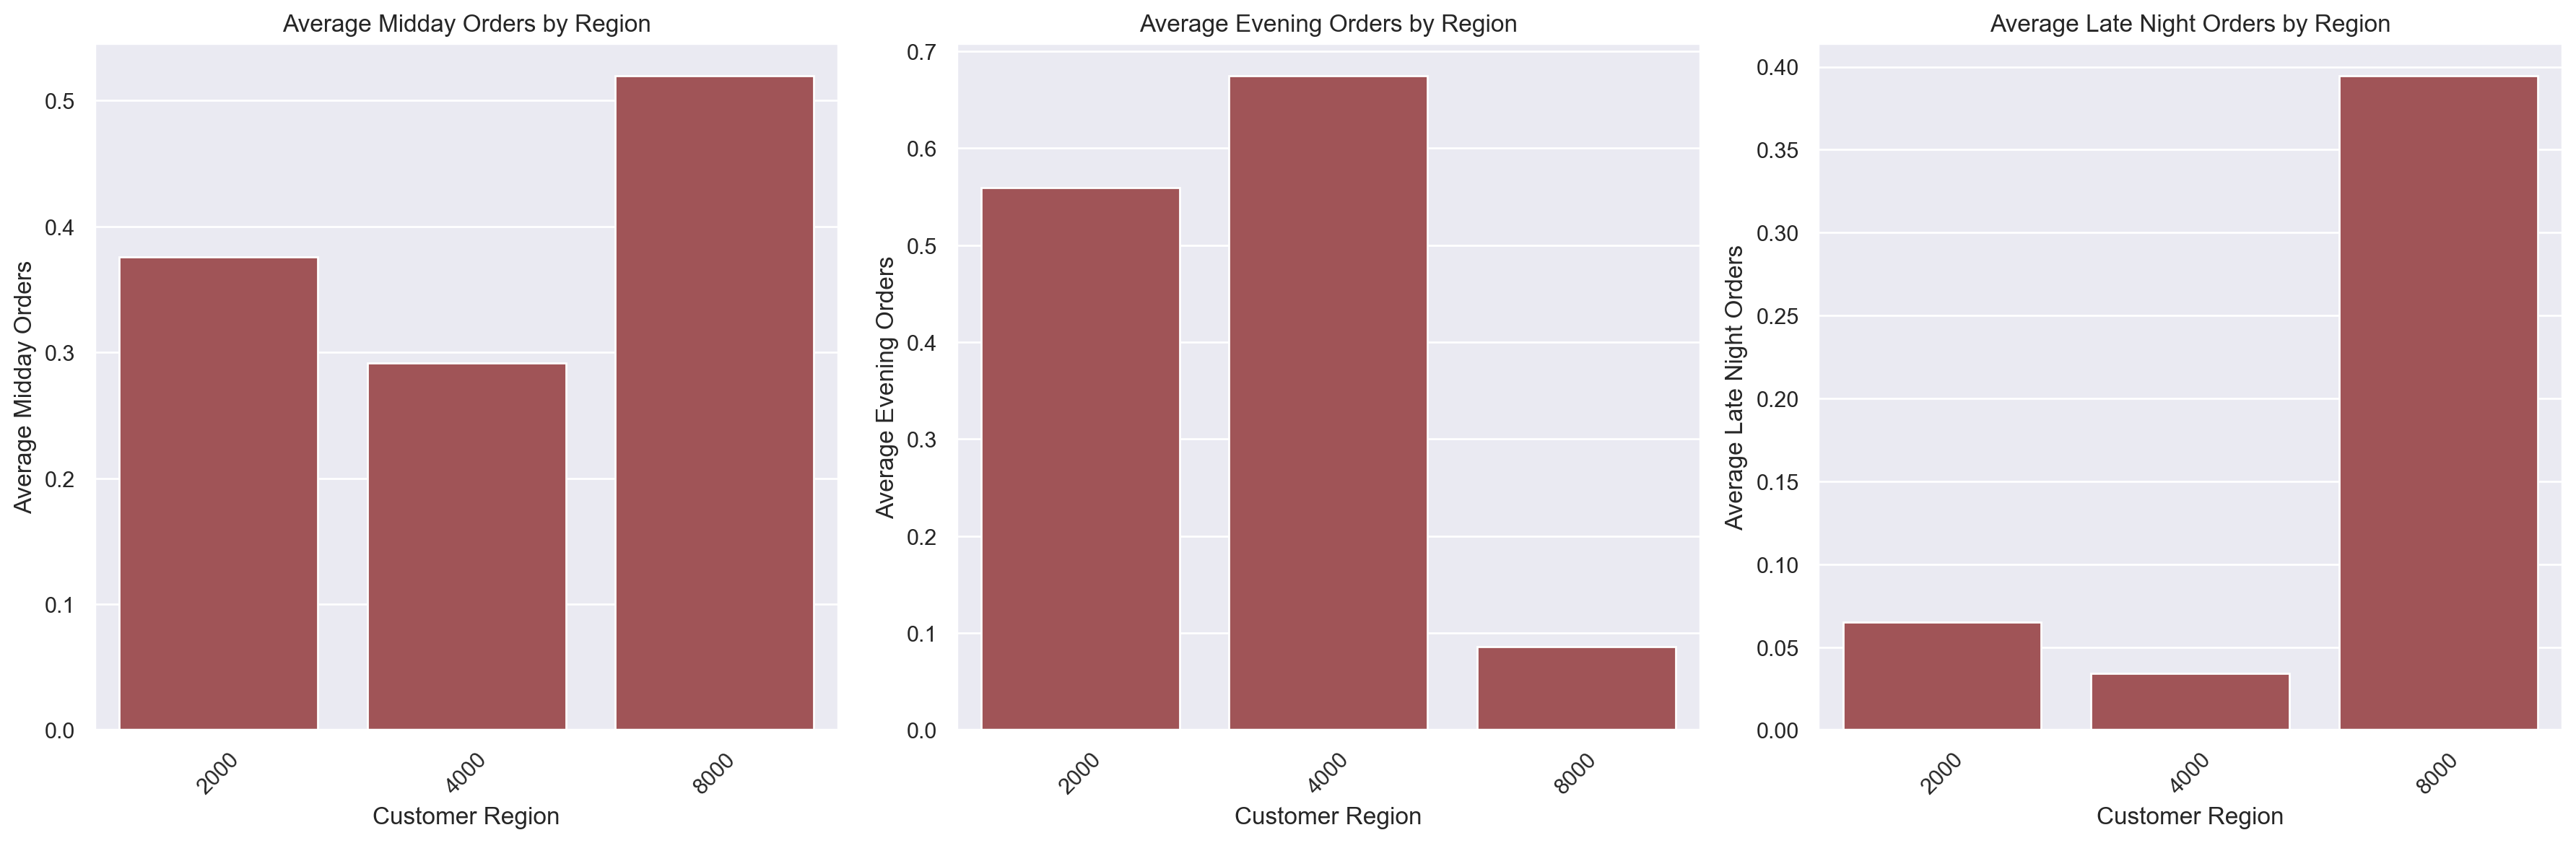

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

time_columns = ['midday_orders', 'evening_orders', 'late_night_orders']

# Loop through each time period
for i, time in enumerate(time_columns):
    # Calculate the average for the current time period
    avg_data = one_time_customers_df.groupby('customer_region')[time].mean().reset_index()
    
    # Plot the data
    sns.barplot(x='customer_region', y=time, data=avg_data, ax=axes[i], color=colors["PR"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {time.replace("_", " ").title()} by Region')
    axes[i].set_xlabel('Customer Region')
    axes[i].set_ylabel(f'Average {time.replace("_", " ").title()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Midday Orders:
- The region with the most midday orders is the 8000 region

Evening Orders
- The region with the most evening orders is the 4000 region, with region 8000 presenting the lowest percentage

Late Night Orders
- The 8000 region has the most late night orders, relatively higher than the other 2 regions, which present very low percentages 

    Weekday per Region

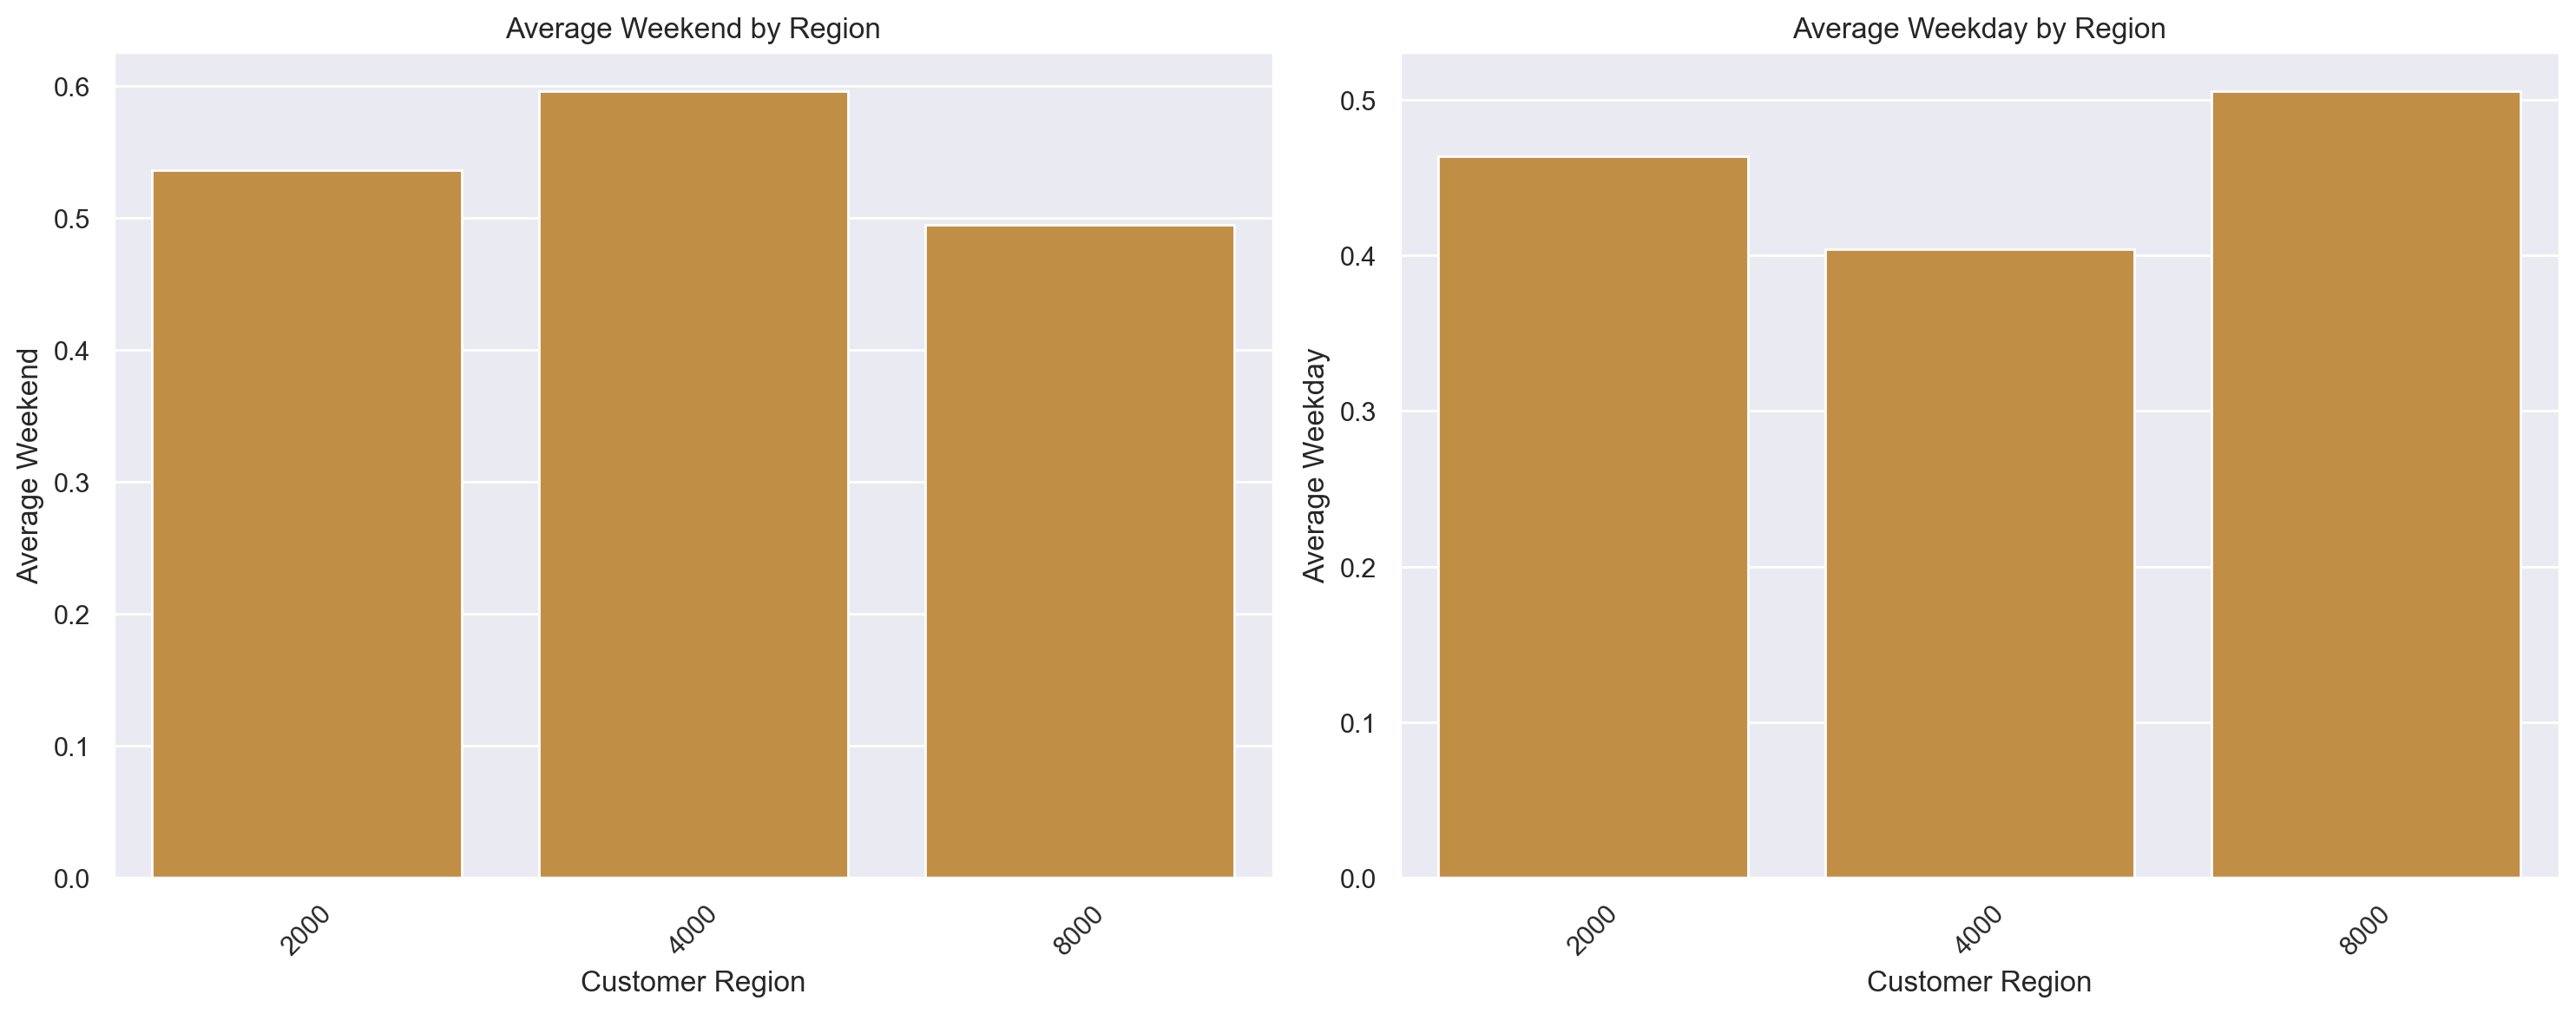

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

dow_column = ['Weekend', 'Weekday']

for i, col in enumerate(dow_column):
    # Calculate the average for the current column
    avg_data = one_time_customers_df.groupby('customer_region')[col].mean().reset_index()
    
    sns.barplot(x='customer_region', y=col, data=avg_data, ax=axes[i], color=colors["Y"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {col} by Region')
    axes[i].set_xlabel('Customer Region')
    axes[i].set_ylabel(f'Average {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


There doesn't seem to be a very high difference in distribution for any of the regions, with region 4000 having slightly higher entries during the Weekend, and the region 8000 having slightly higher entries during the Weekday

    Cuisines per Region

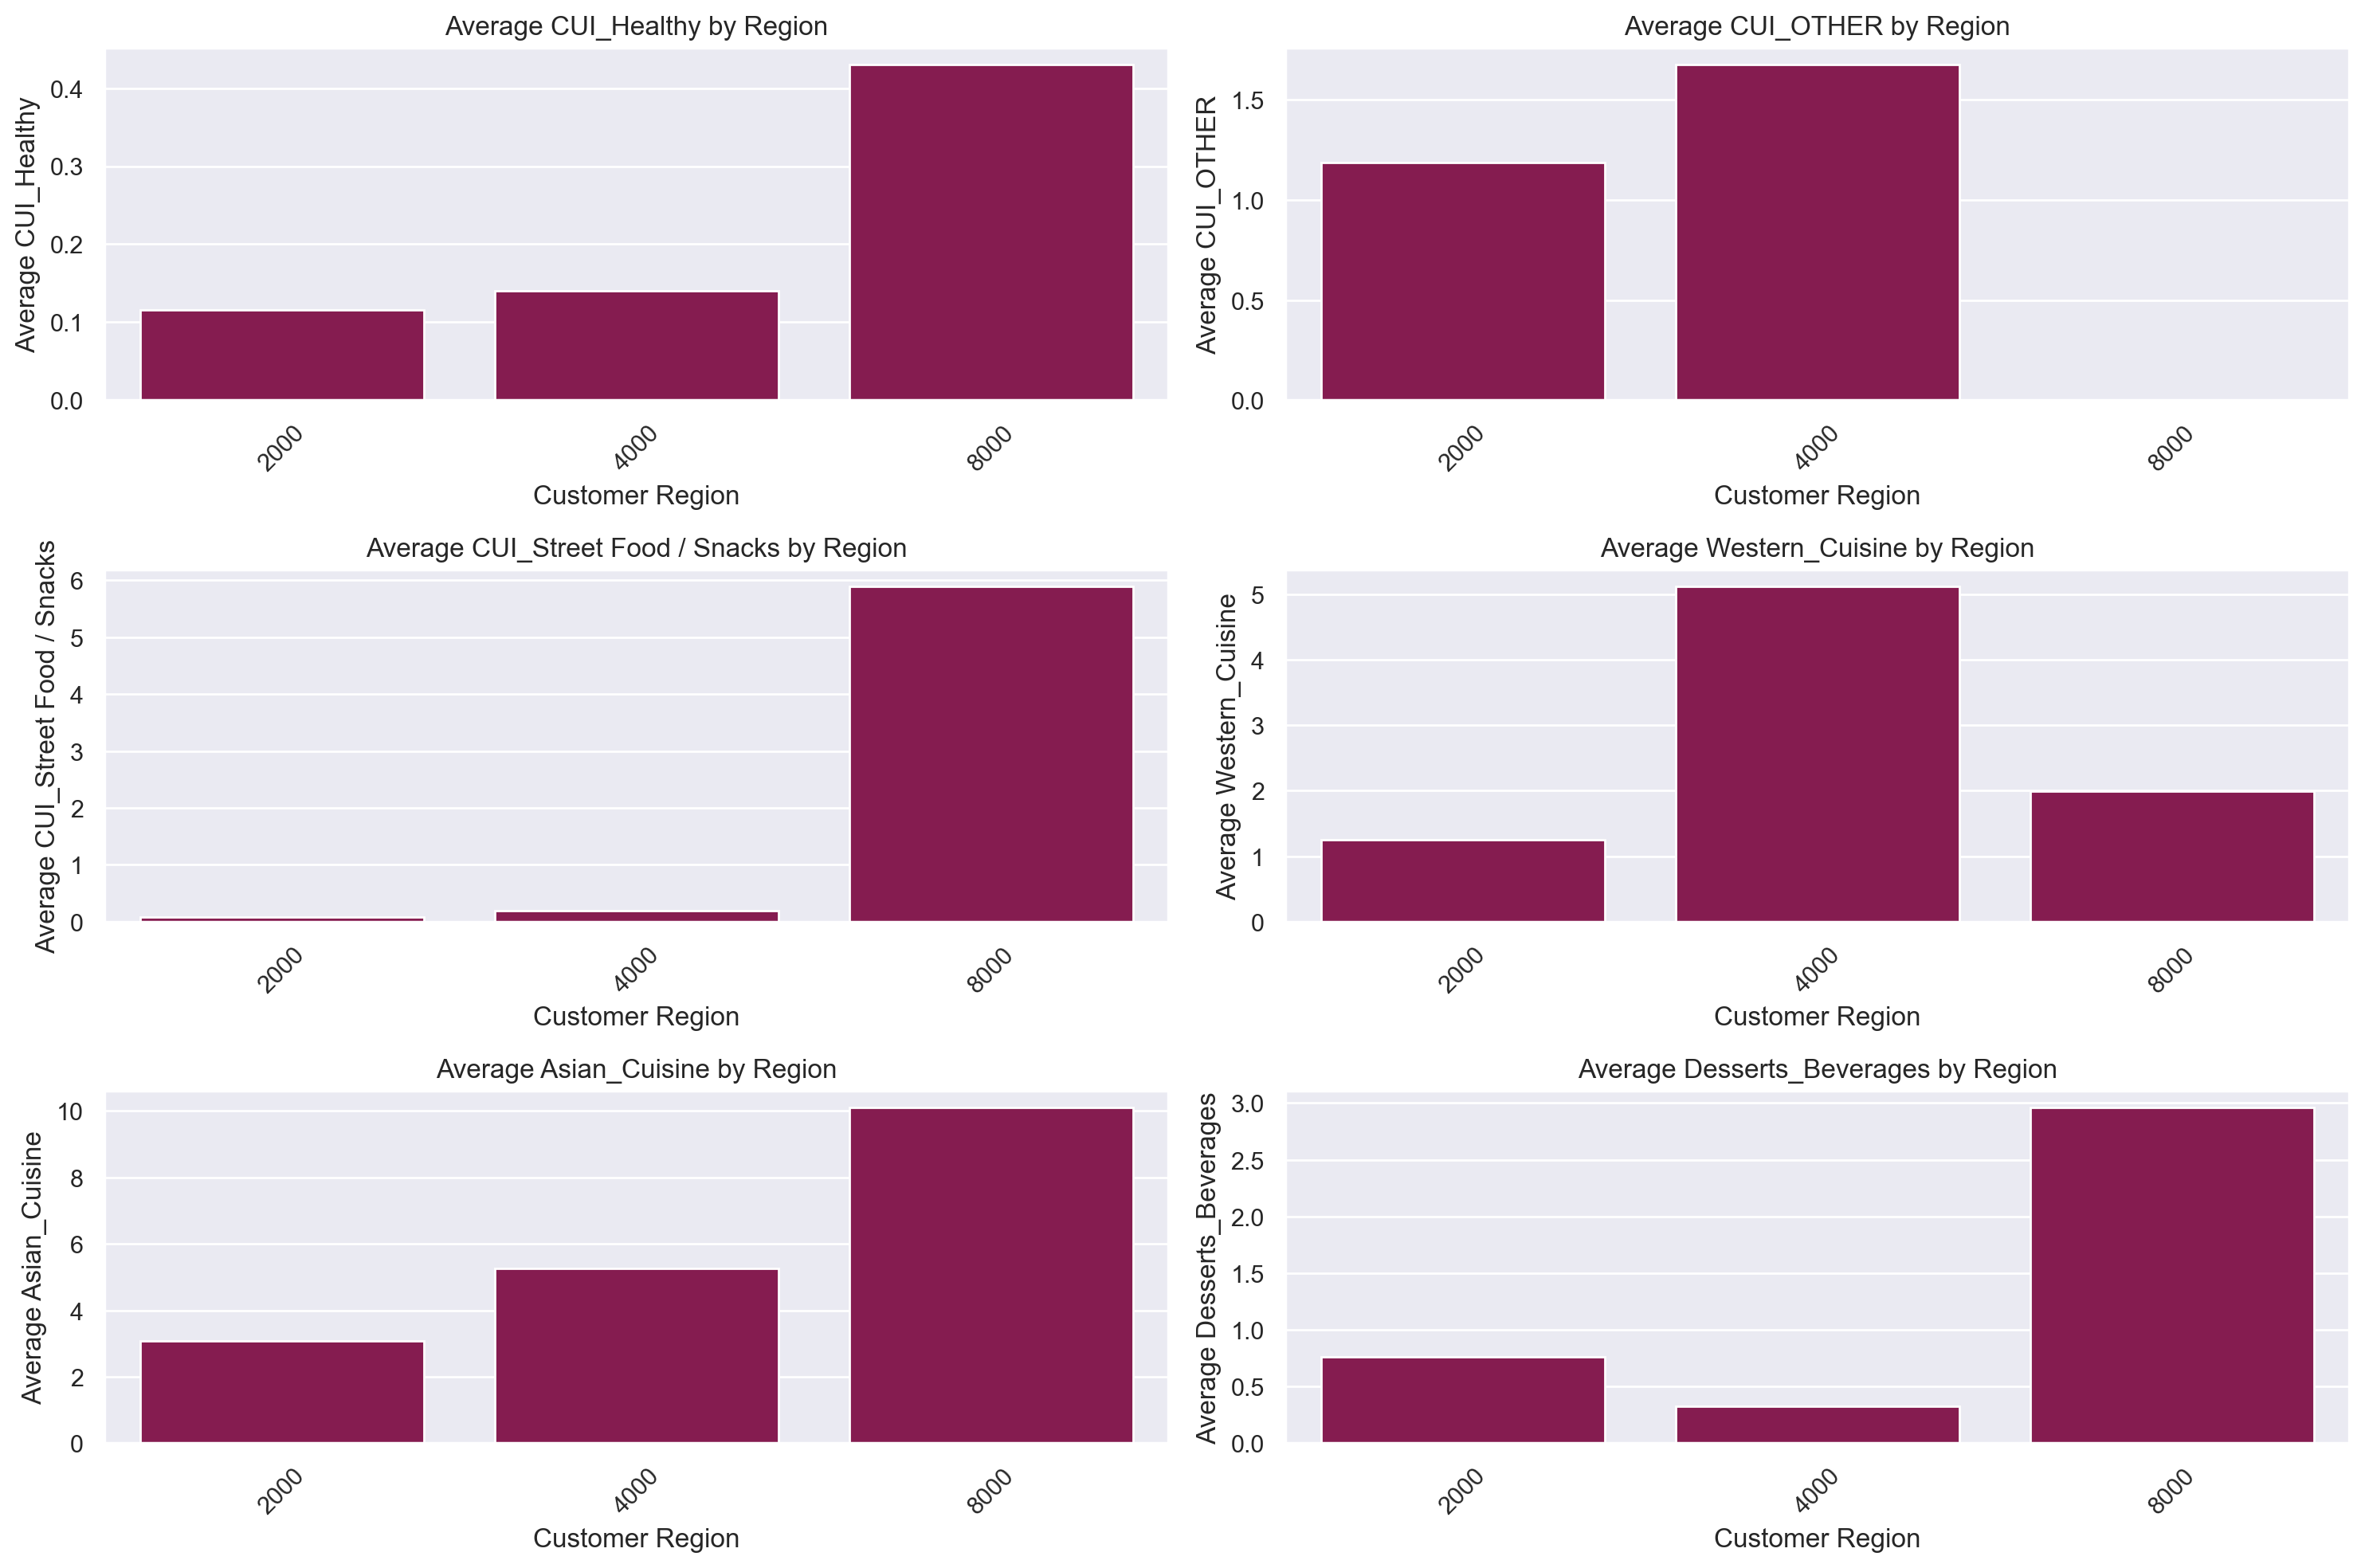

In [33]:
cuisine_columns = ['CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']

fig, axes = plt.subplots(3, 2, figsize=(15, 10)) 

axes = axes.flatten()

#Running through each cuisine column and create a bar plot for the average value by customer_region
for i, cuisine_column in enumerate(cuisine_columns):
    avg_data = one_time_customers_df.groupby('customer_region')[cuisine_column].mean().reset_index()
    
    sns.barplot(x='customer_region', y=cuisine_column, data=avg_data, ax=axes[i], color=colors["M"])
    
    axes[i].set_title(f'Average {cuisine_column} by Region')
    axes[i].set_xlabel('Customer Region')
    axes[i].set_ylabel(f'Average {cuisine_column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Region 8000
- It seems one time customers form this region, mostly bought from CUI_Healthy, CUI_Street Food/Snacks, Asian cuisine, and Desserts_Beverages

Region 2000
- One time customers from this region, do not have the highest entries from any of the cuisnes, but it is the second highest in the CUI_Other and it has really low entries in the CUI_Street Food/Snacks.

Region 4000
- One time customers from this region, mostly buy from Western_Cusines, and CUI_Other, they also bought from Asian_cuisine and CUI_Healthy. 

#### **Payment Method**

In [34]:
one_time_customers_df['payment_method'].value_counts()

payment_method
CARD    2836
CASH    2207
DIGI    1865
Name: count, dtype: int64

Payment method distribution across does not seem to present any highlight, or a payment method that really stands out.

    Time of the day by payment method

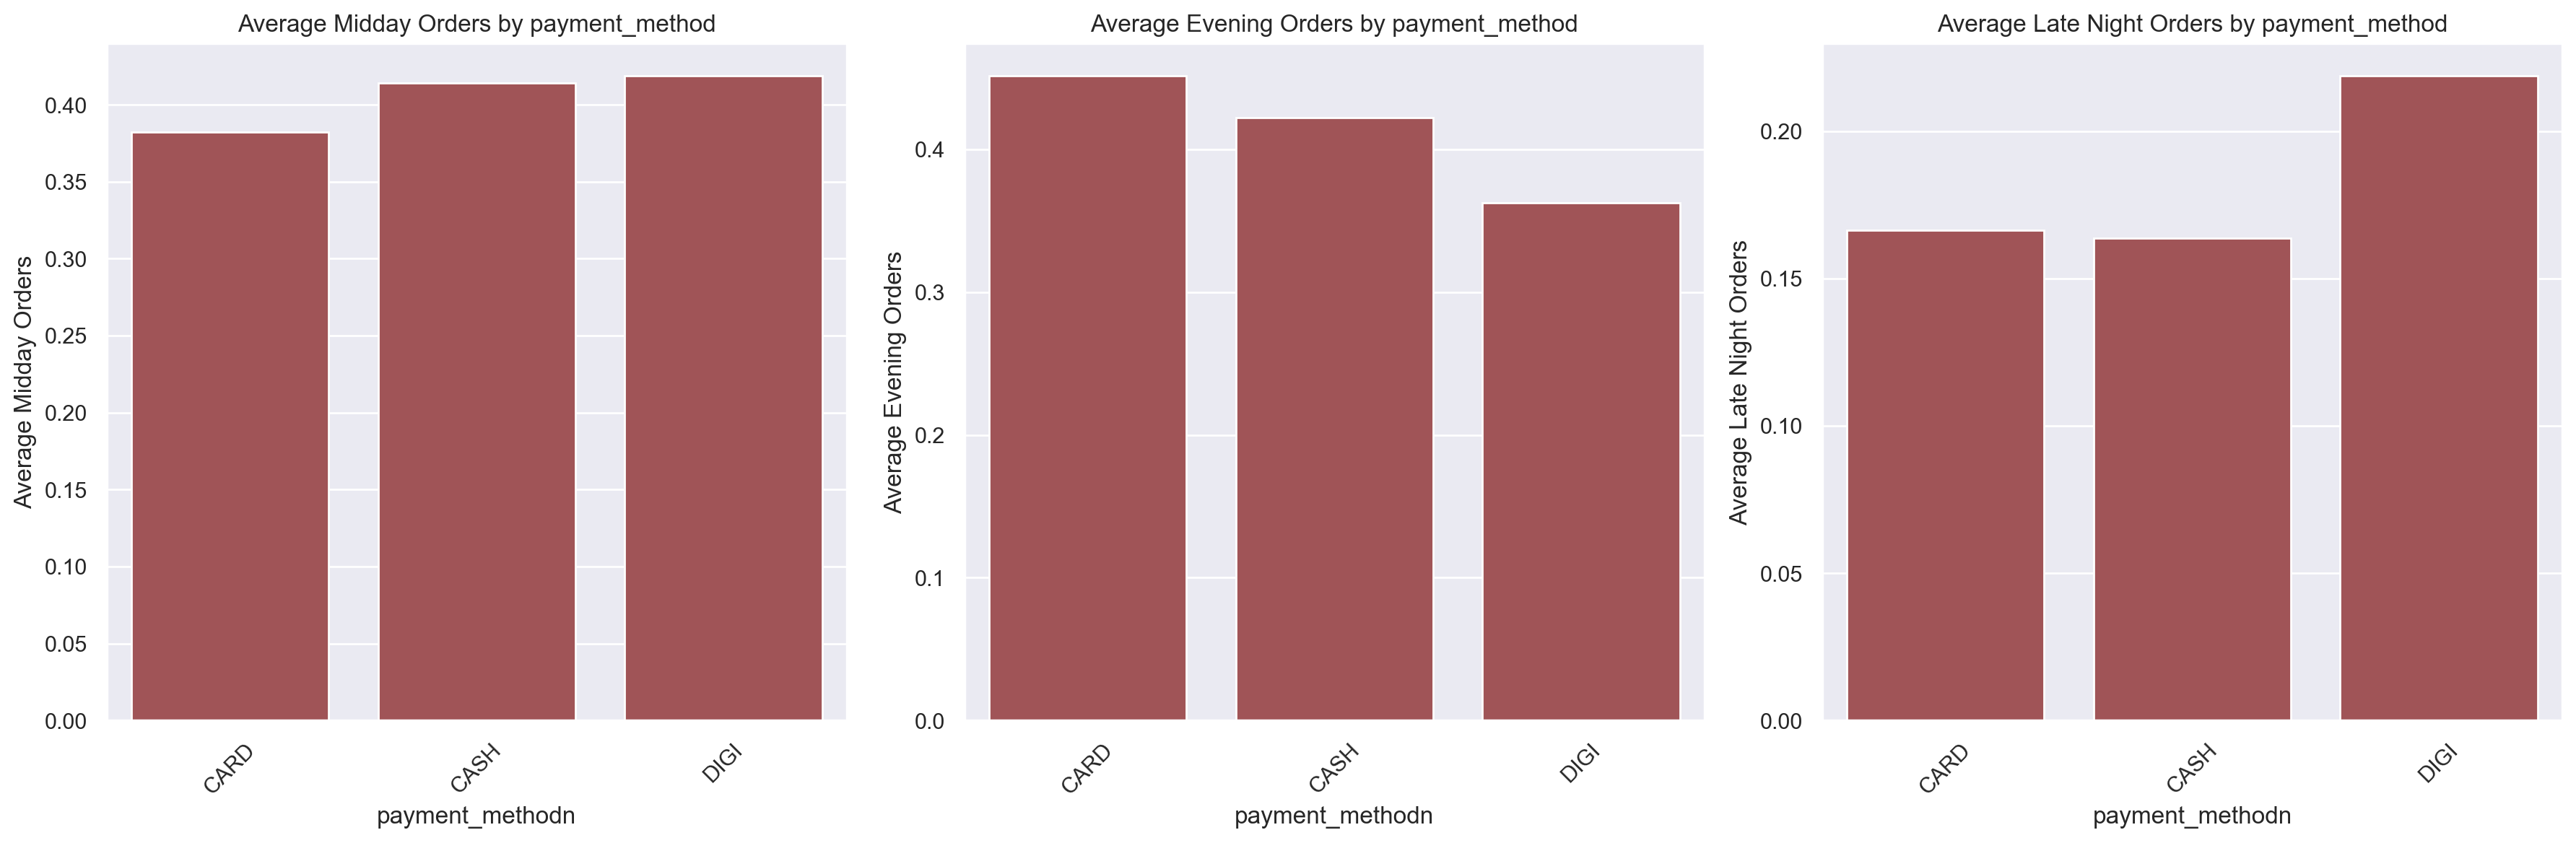

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

time_columns = ['midday_orders', 'evening_orders', 'late_night_orders']

# Loop through each time period
for i, time in enumerate(time_columns):
    # Calculate the average for the current time period
    avg_data = one_time_customers_df.groupby('payment_method')[time].mean().reset_index()
    
    # Plot the data
    sns.barplot(x='payment_method', y=time, data=avg_data, ax=axes[i], color=colors["PR"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {time.replace("_", " ").title()} by payment_method')
    axes[i].set_xlabel('payment_methodn')
    axes[i].set_ylabel(f'Average {time.replace("_", " ").title()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Payment method accross the different times of the day do not differ much, except that, during the late night orders, most of the orders are paid by DIGITAL, while during the evenings, most of the orders are paid by CARD.

    Weekday by payment method

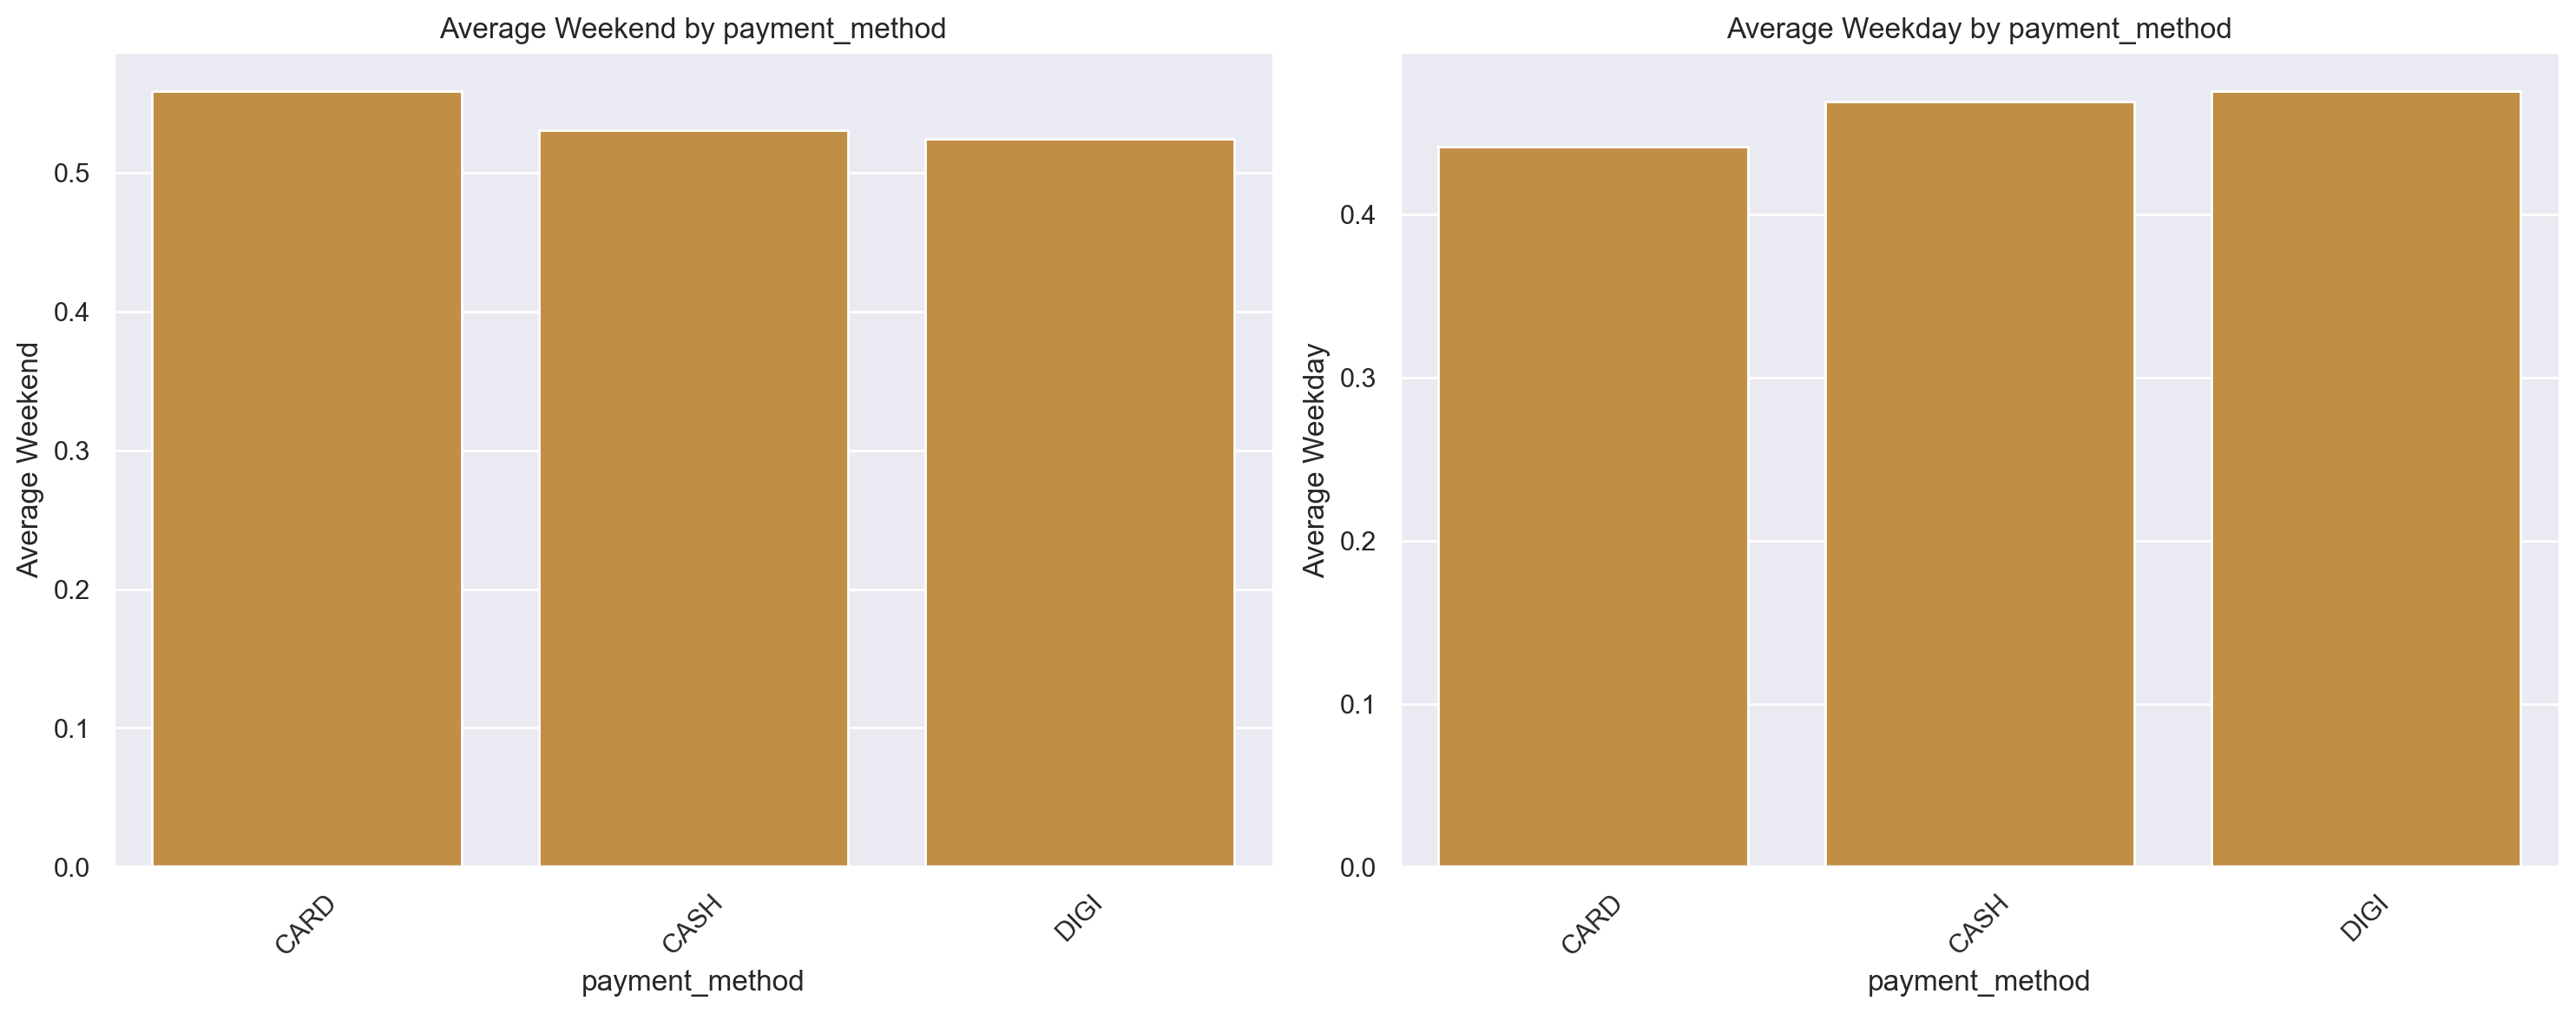

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

dow_column = ['Weekend', 'Weekday']

for i, col in enumerate(dow_column):
    # Calculate the average for the current column
    avg_data = one_time_customers_df.groupby('payment_method')[col].mean().reset_index()
    
    sns.barplot(x='payment_method', y=col, data=avg_data, ax=axes[i], color=colors["Y"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {col} by payment_method')
    axes[i].set_xlabel('payment_method')
    axes[i].set_ylabel(f'Average {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


There doesn't seem to be a high or relevant difference in payment methods between Weekday and Weekend orders.

    Cuisines by payment method


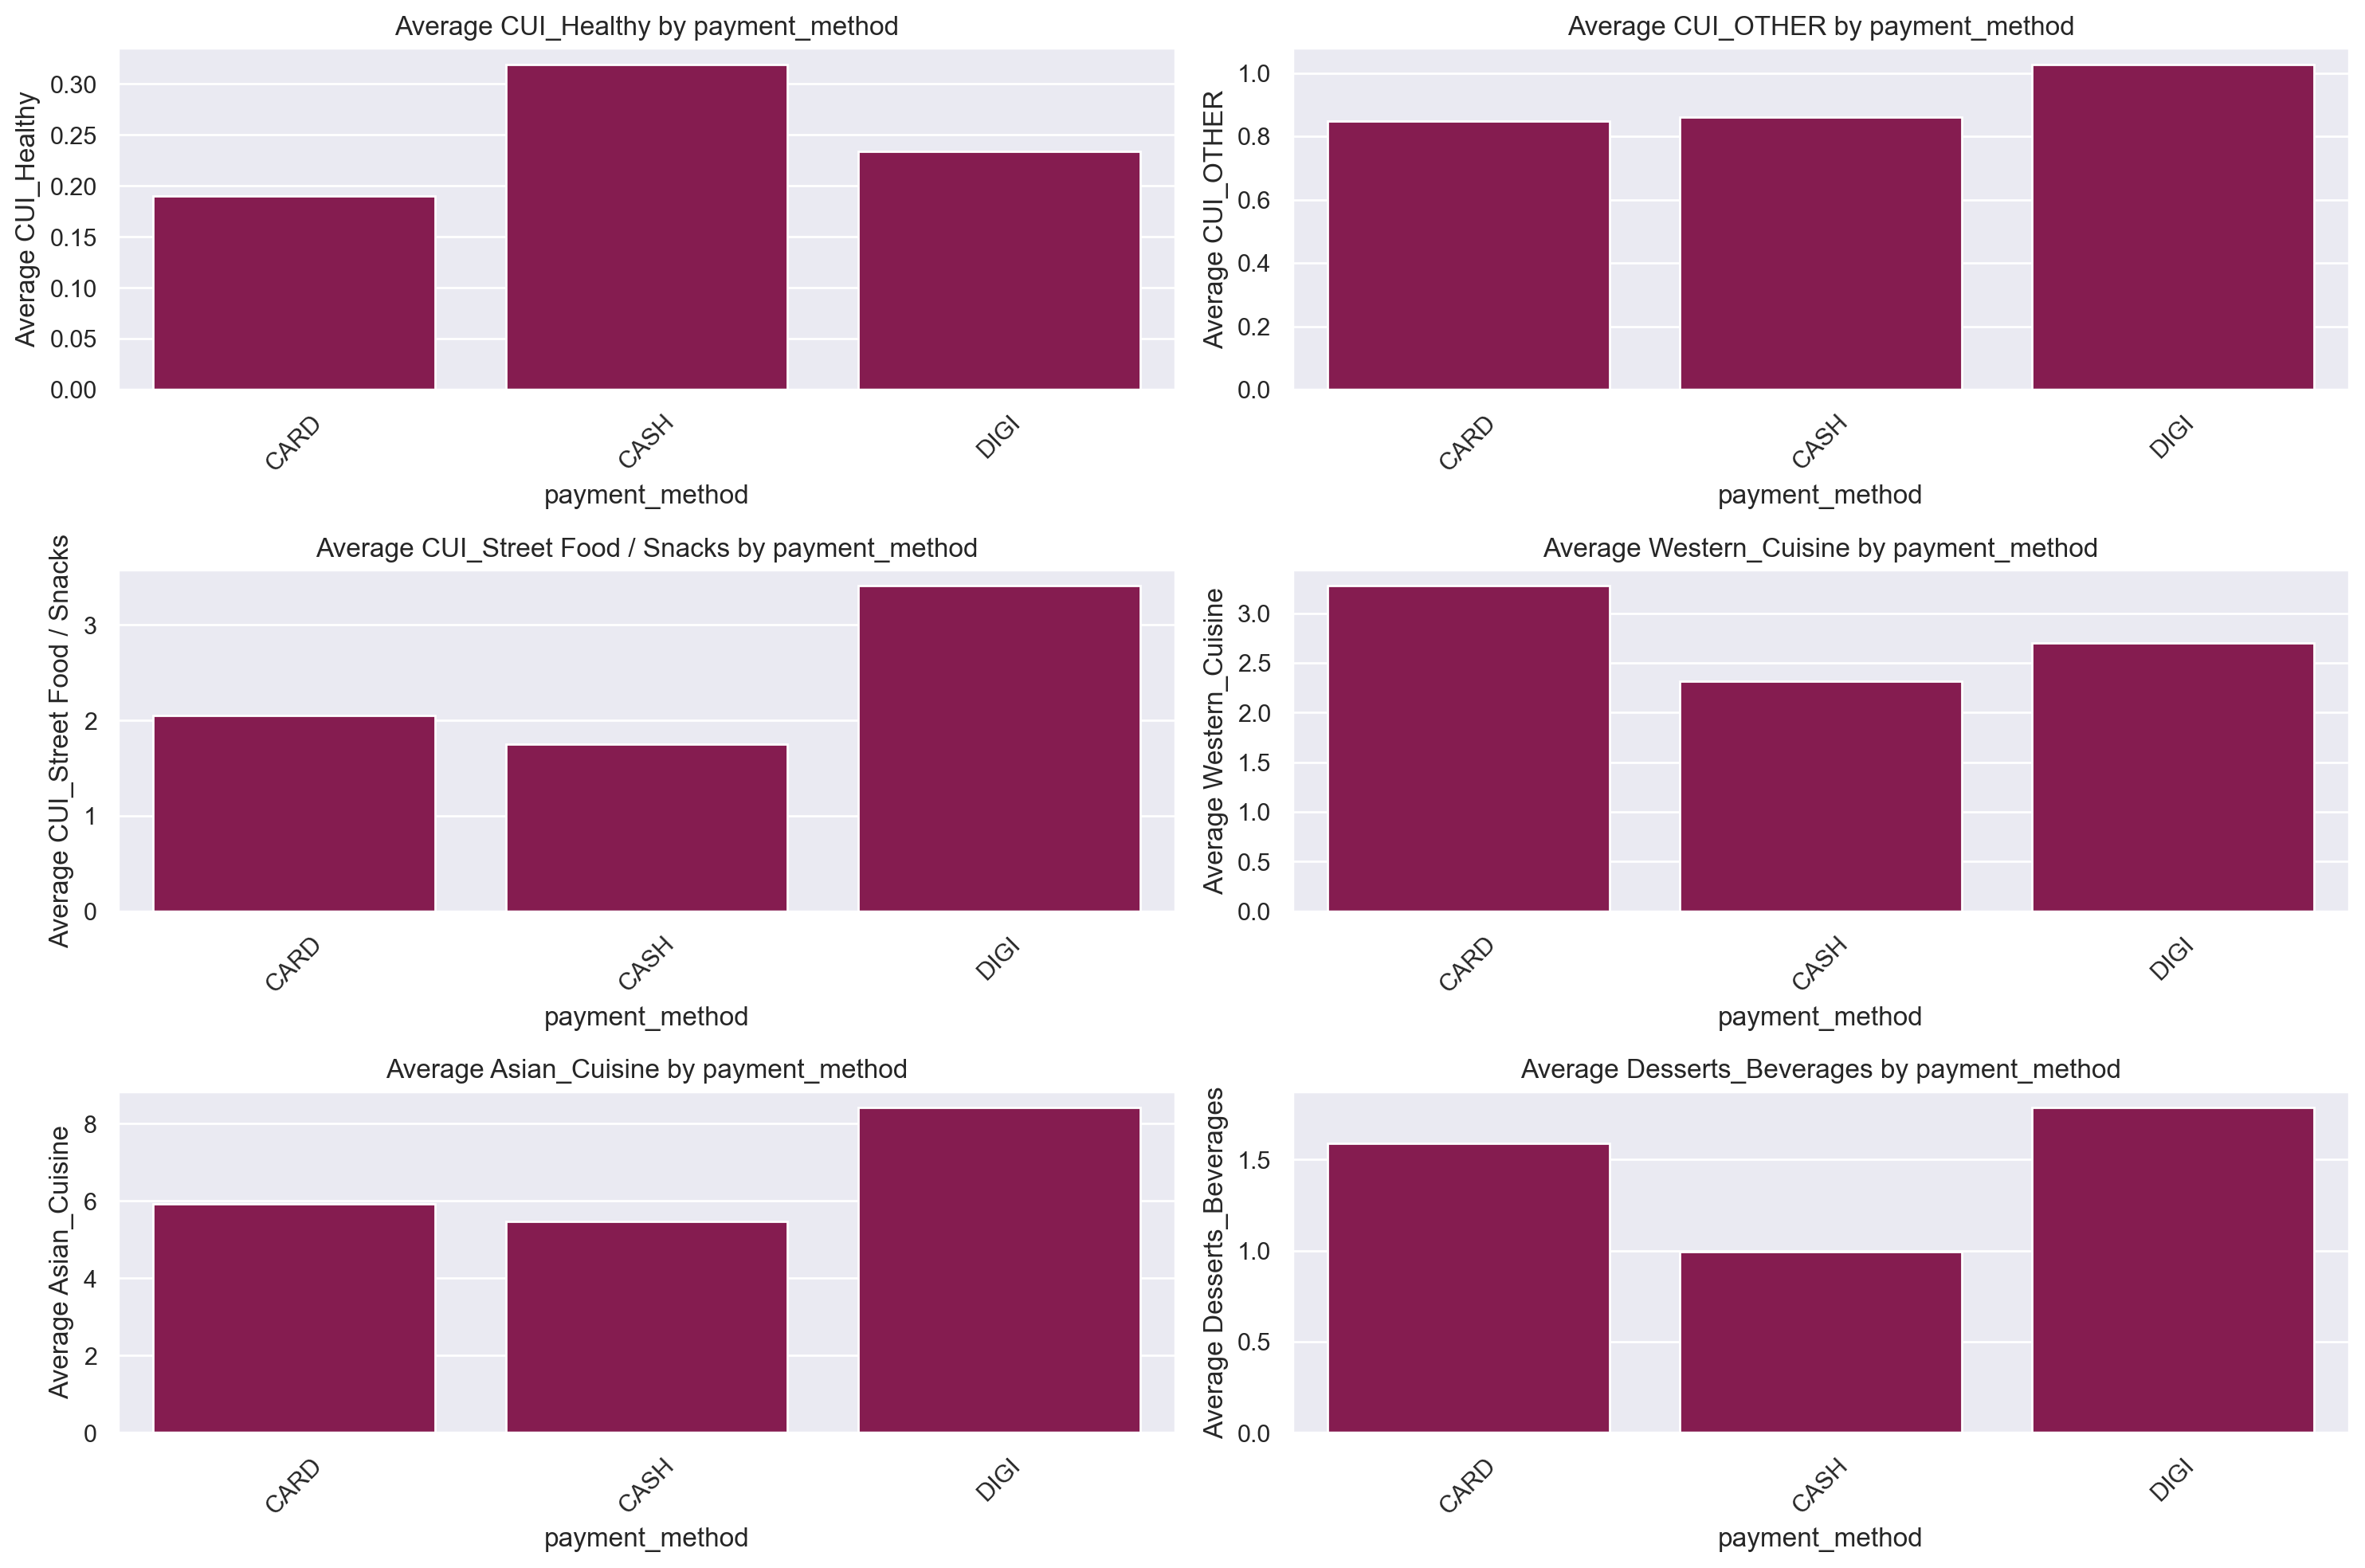

In [37]:
cuisine_columns = ['CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']

fig, axes = plt.subplots(3, 2, figsize=(15, 10)) 

axes = axes.flatten()

#Running through each cuisine column and create a bar plot for the average value by payment_method
for i, cuisine_column in enumerate(cuisine_columns):
    avg_data = one_time_customers_df.groupby('payment_method')[cuisine_column].mean().reset_index()
    
    sns.barplot(x='payment_method', y=cuisine_column, data=avg_data, ax=axes[i], color=colors["M"])
    
    axes[i].set_title(f'Average {cuisine_column} by payment_method')
    axes[i].set_xlabel('payment_method')
    axes[i].set_ylabel(f'Average {cuisine_column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

- Most order in the CUI_Healthy were paid by CASH.
- For CUI_Street Food, most of the orders were paid by DIGI
- There seems to be no relevant difference in payment methods across the cuisines.

#### Last Promo

In [38]:
one_time_customers_df['last_promo'].value_counts()

last_promo
DELIVERY    2513
NOPROMO     2273
DISCOUNT    1257
FREEBIE      865
Name: count, dtype: int64

There seems to be very little orders done by FREEBIE type of promotion

    Time of day by last promotion

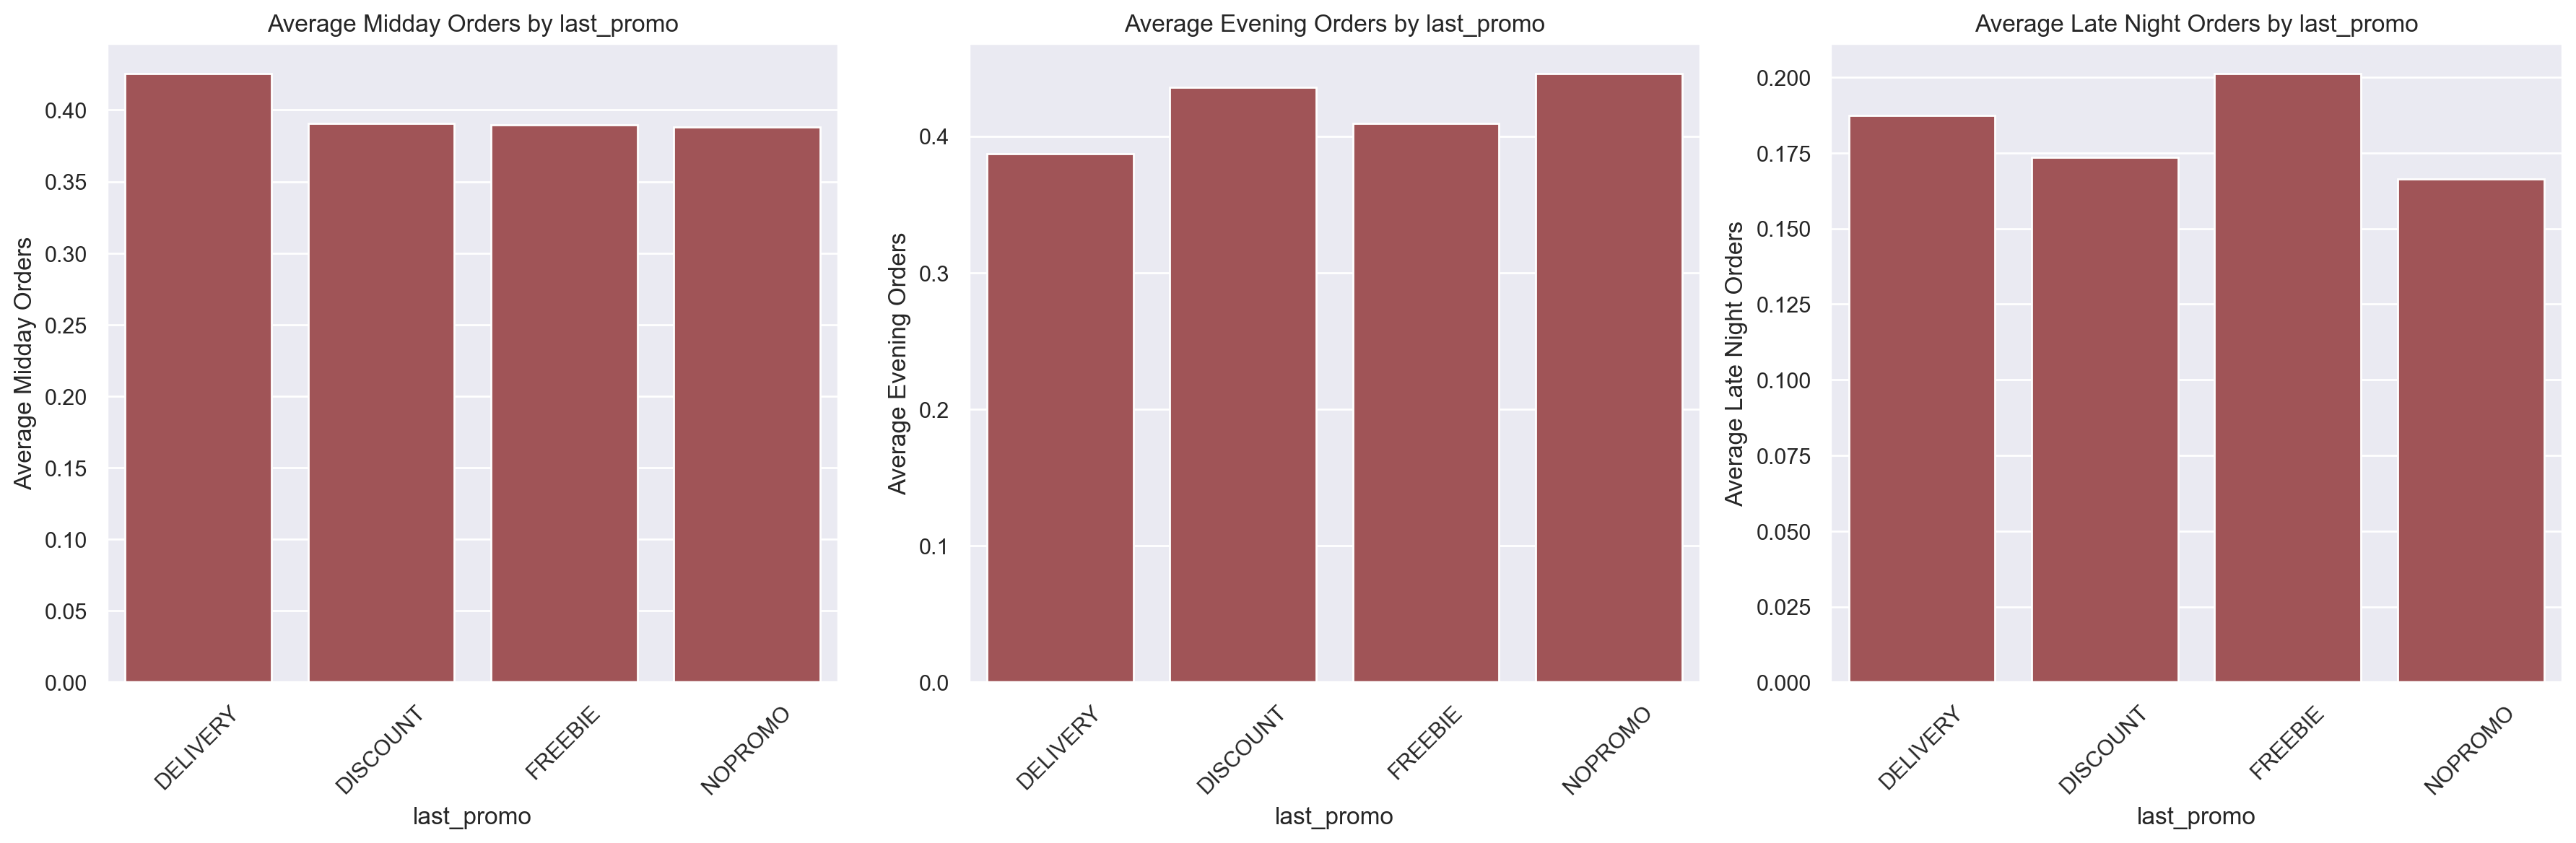

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

time_columns = ['midday_orders', 'evening_orders', 'late_night_orders']

# Loop through each time period
for i, time in enumerate(time_columns):
    # Calculate the average for the current time period
    avg_data = one_time_customers_df.groupby('last_promo')[time].mean().reset_index()
    
    # Plot the data
    sns.barplot(x='last_promo', y=time, data=avg_data, ax=axes[i], color=colors["PR"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {time.replace("_", " ").title()} by last_promo')
    axes[i].set_xlabel('last_promo')
    axes[i].set_ylabel(f'Average {time.replace("_", " ").title()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- FREEBIE is the type of promotion wihtt he least entries, but it seems msot of the late night orders are done over the FREEBIE Promotion type.

    Weekday by promotion

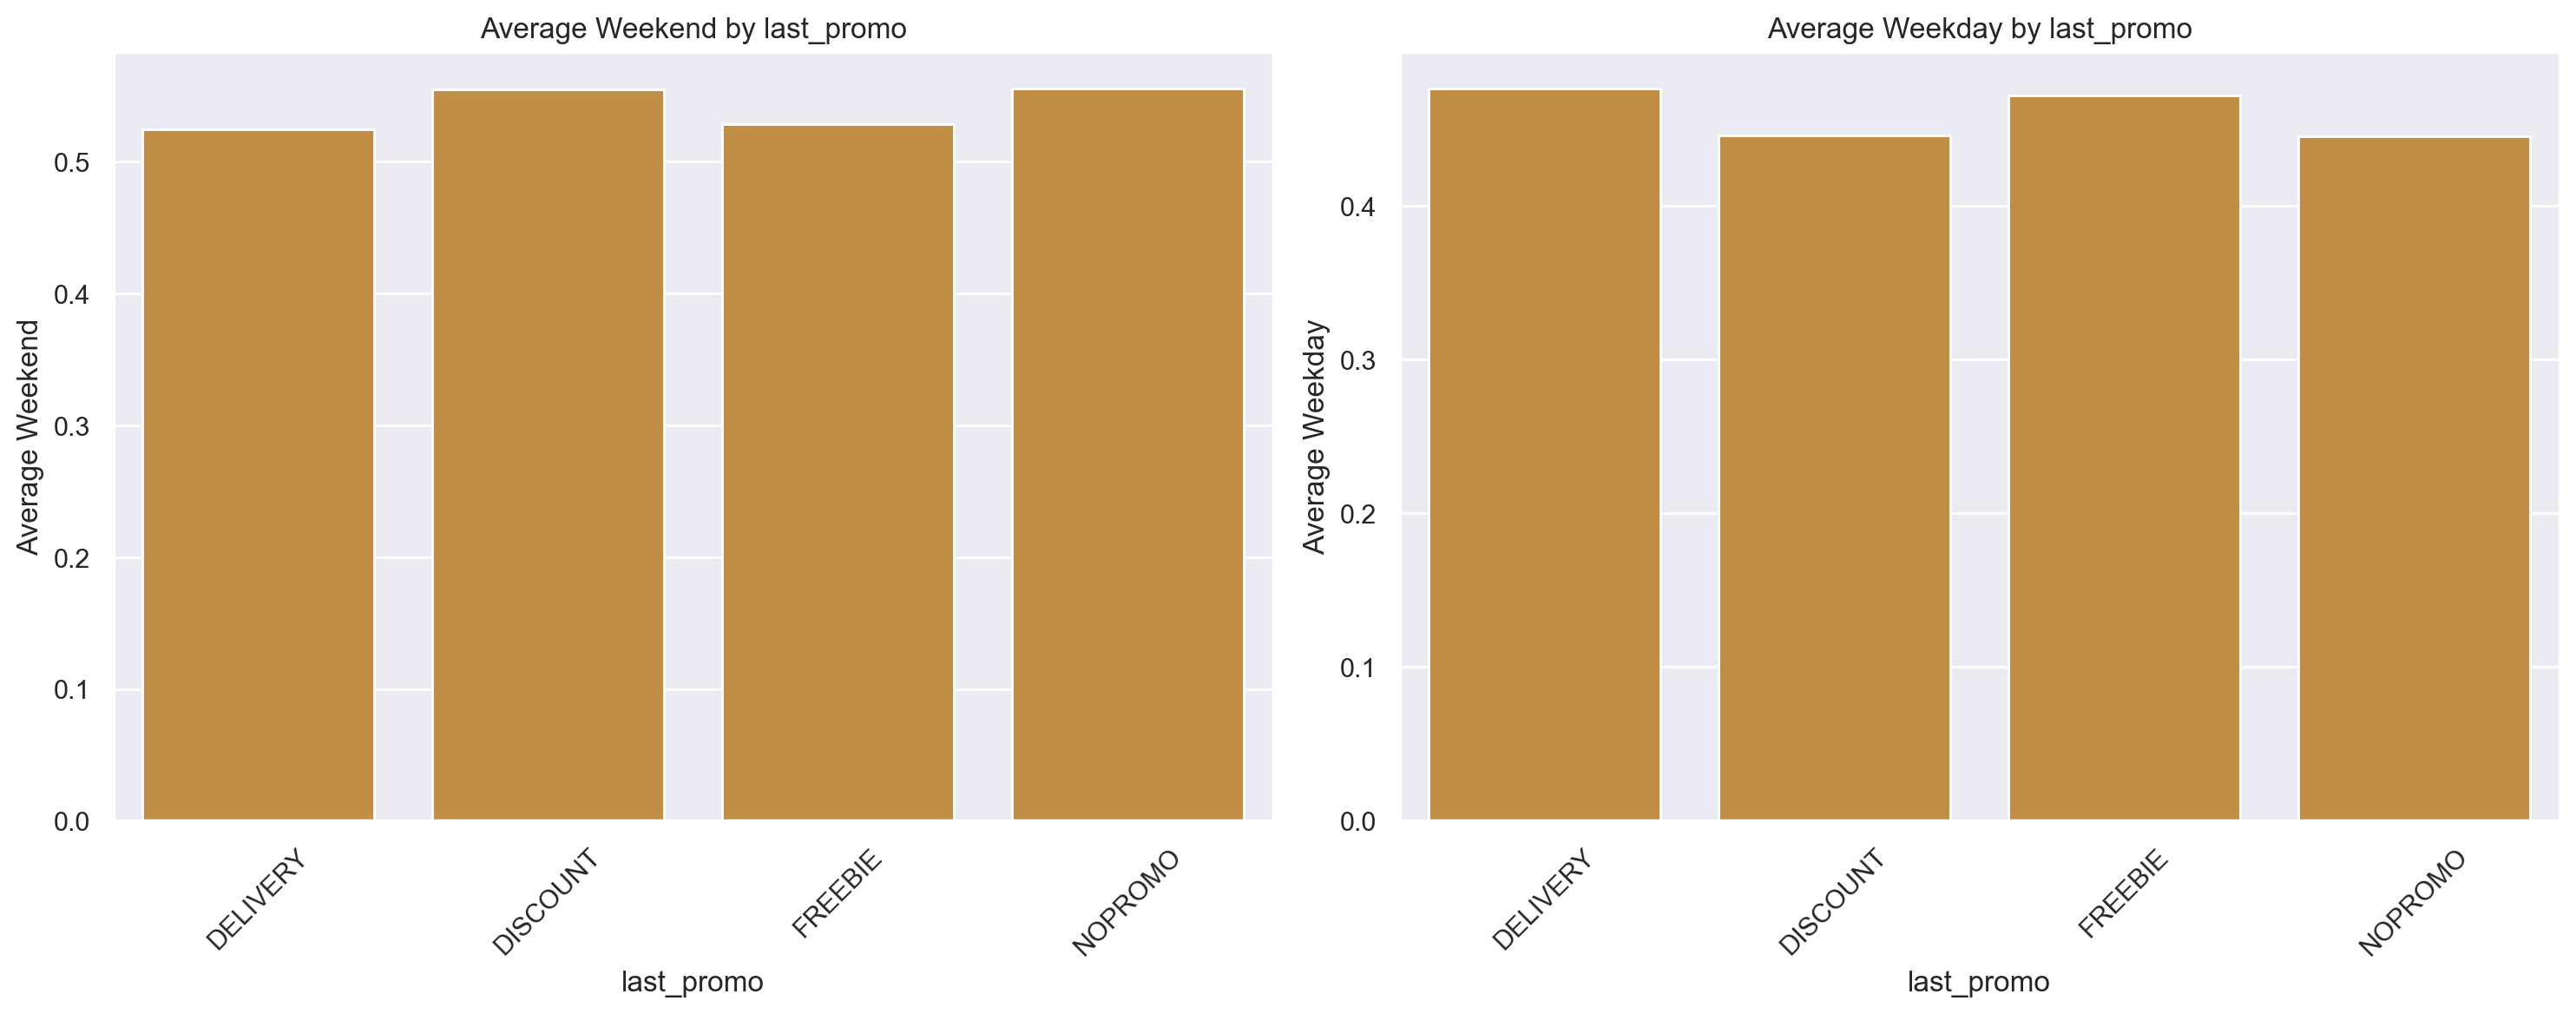

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

dow_column = ['Weekend', 'Weekday']

for i, col in enumerate(dow_column):
    # Calculate the average for the current column
    avg_data = one_time_customers_df.groupby('last_promo')[col].mean().reset_index()
    
    sns.barplot(x='last_promo', y=col, data=avg_data, ax=axes[i], color=colors["Y"])
    
    # Set titles and labels
    axes[i].set_title(f'Average {col} by last_promo')
    axes[i].set_xlabel('last_promo')
    axes[i].set_ylabel(f'Average {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


There is no relevant difference in the type of promtoions per Weekday and Weekend.

    Cuisines by Promotion

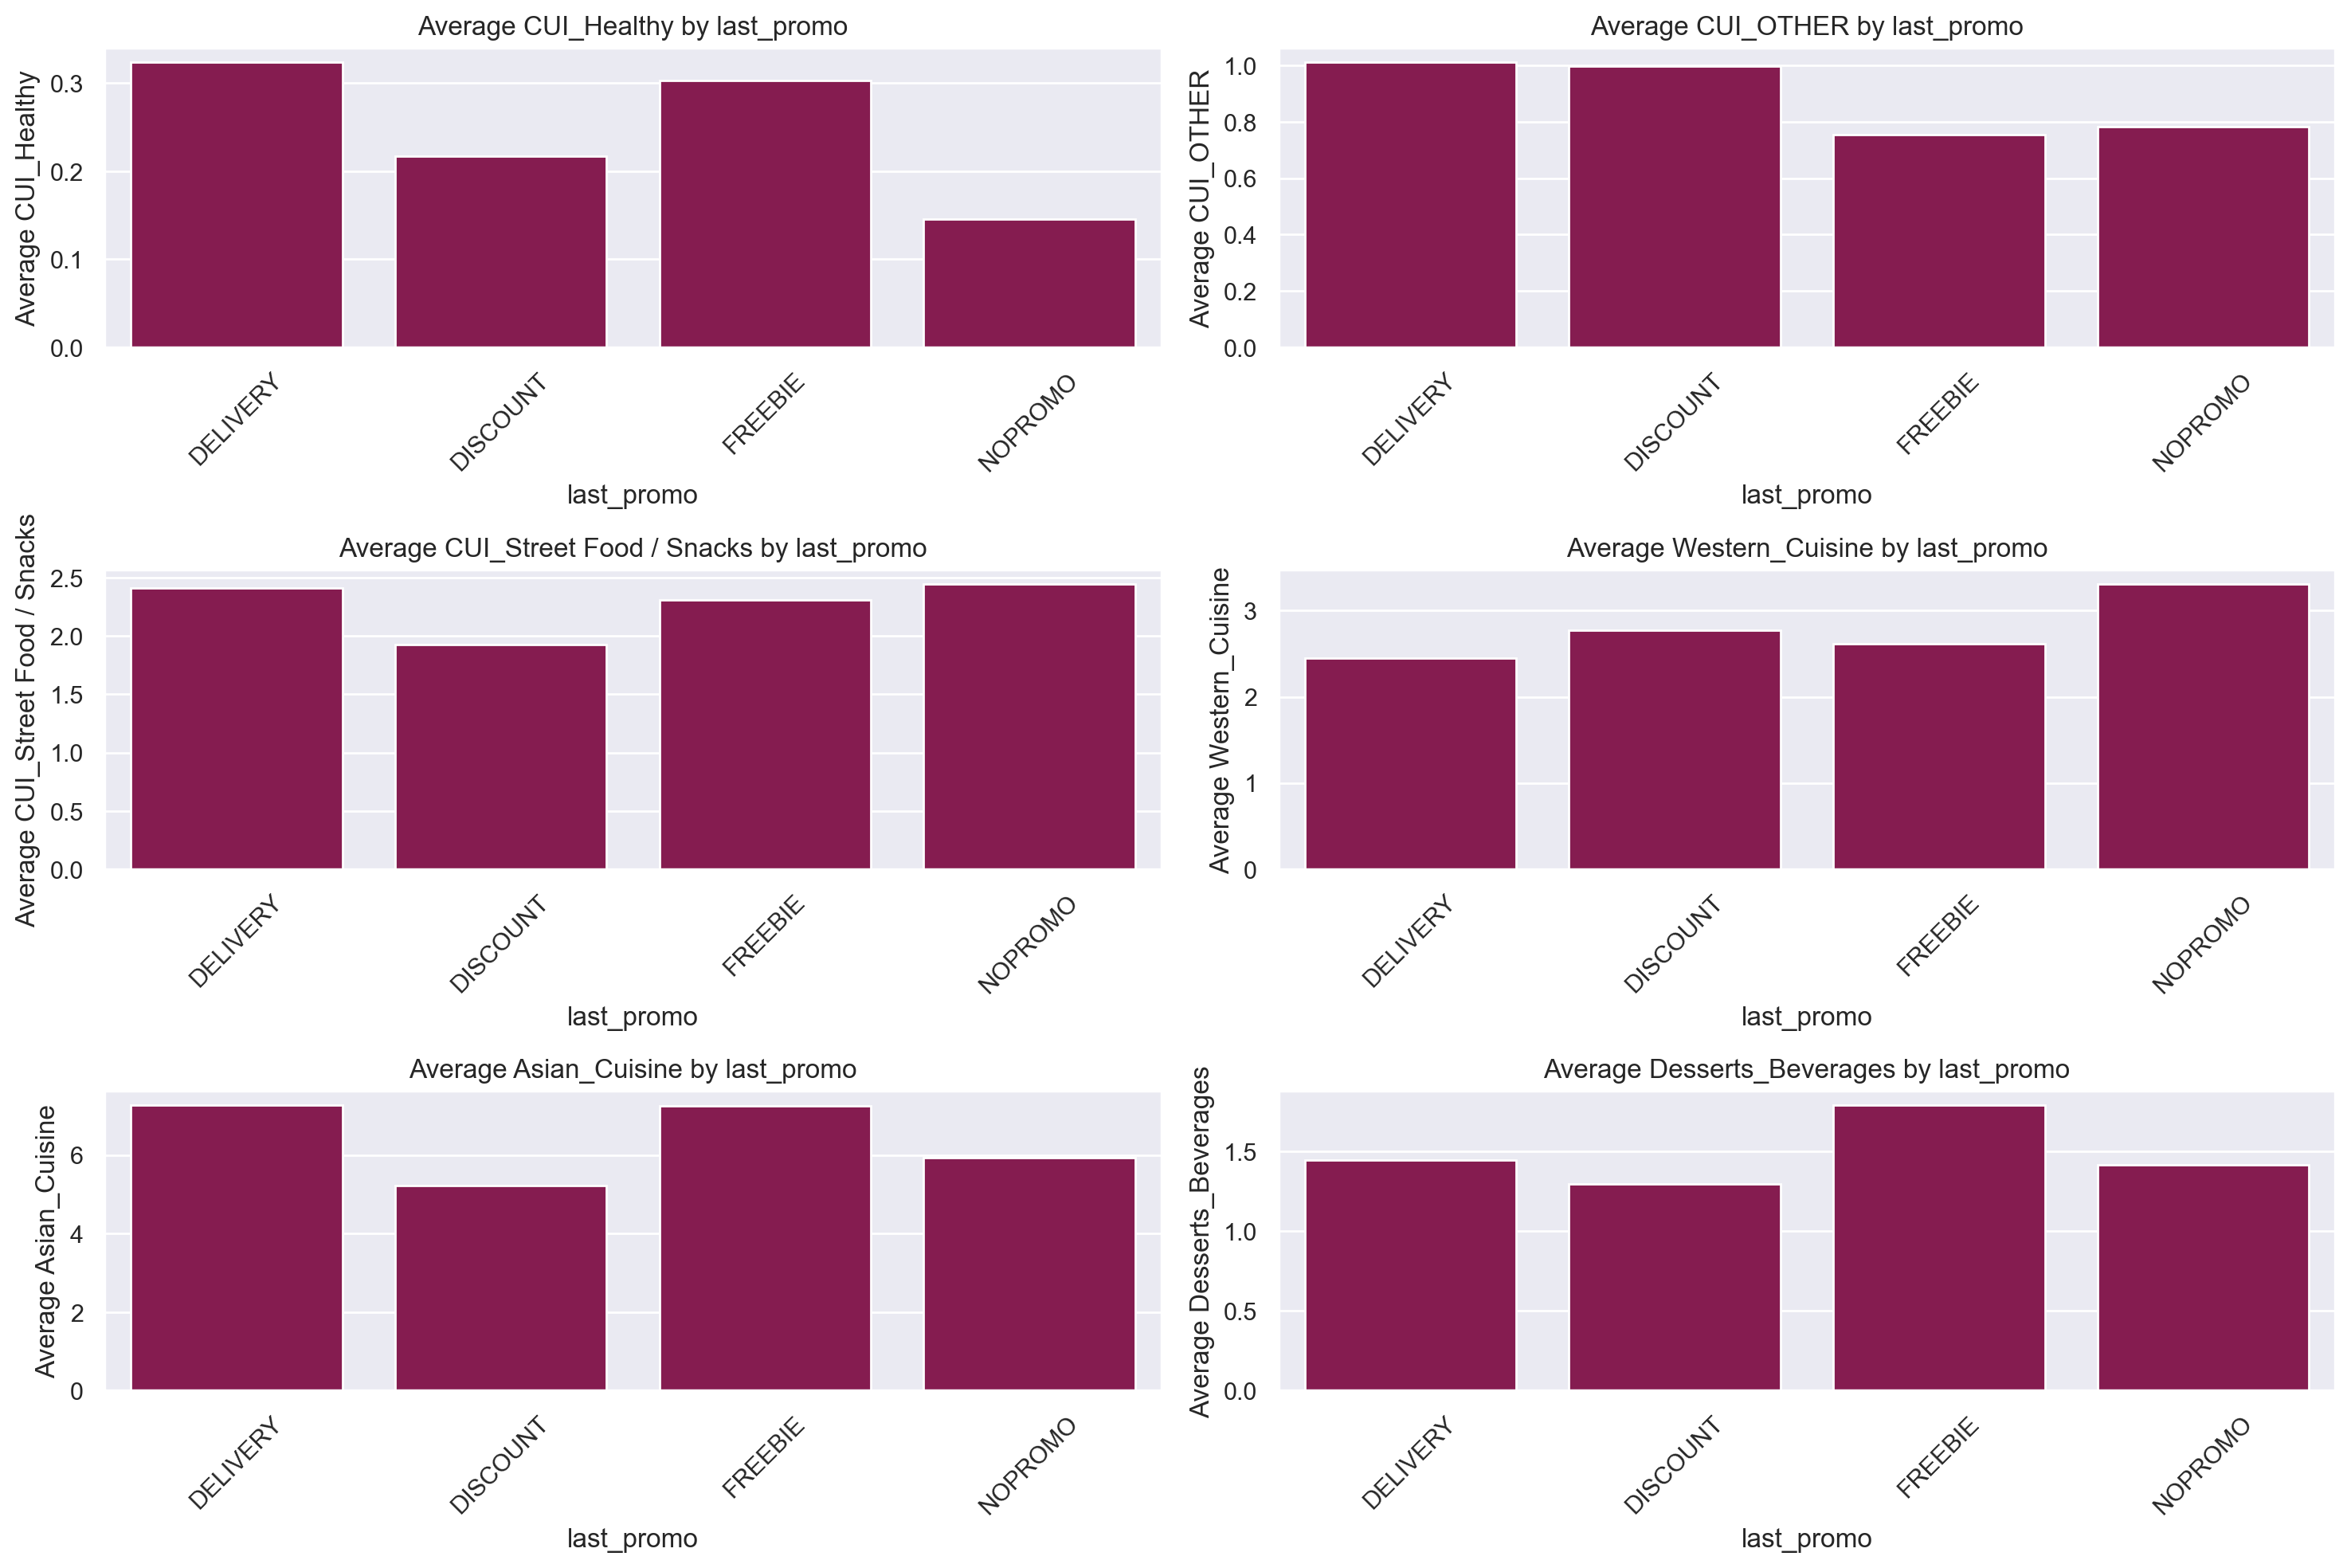

In [39]:
cuisine_columns = ['CUI_Healthy', 'CUI_OTHER', 'CUI_Street Food / Snacks','Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages']

fig, axes = plt.subplots(3, 2, figsize=(15, 10)) 

axes = axes.flatten()

#Running through each cuisine column and create a bar plot for the average value by last_promo
for i, cuisine_column in enumerate(cuisine_columns):
    avg_data = one_time_customers_df.groupby('last_promo')[cuisine_column].mean().reset_index()
    
    sns.barplot(x='last_promo', y=cuisine_column, data=avg_data, ax=axes[i], color=colors["M"])
    
    axes[i].set_title(f'Average {cuisine_column} by last_promo')
    axes[i].set_xlabel('last_promo')
    axes[i].set_ylabel(f'Average {cuisine_column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

- The "DELIVERY" type of promotion is very common in the cuisines: CUI_Street Food; Asian_cuisine; CUI_Healthy and CUI_Other.
- The "FREEBIE" type of promotion is commonly used in the cuisines: DESSERTS_BEVERAGES; Asian_Cuisine; and CUI_Street Food/Snacks.
- DISCOUNT promotions are very common in Western_cusines and CUI_Others.

#### Customer region vs payment method

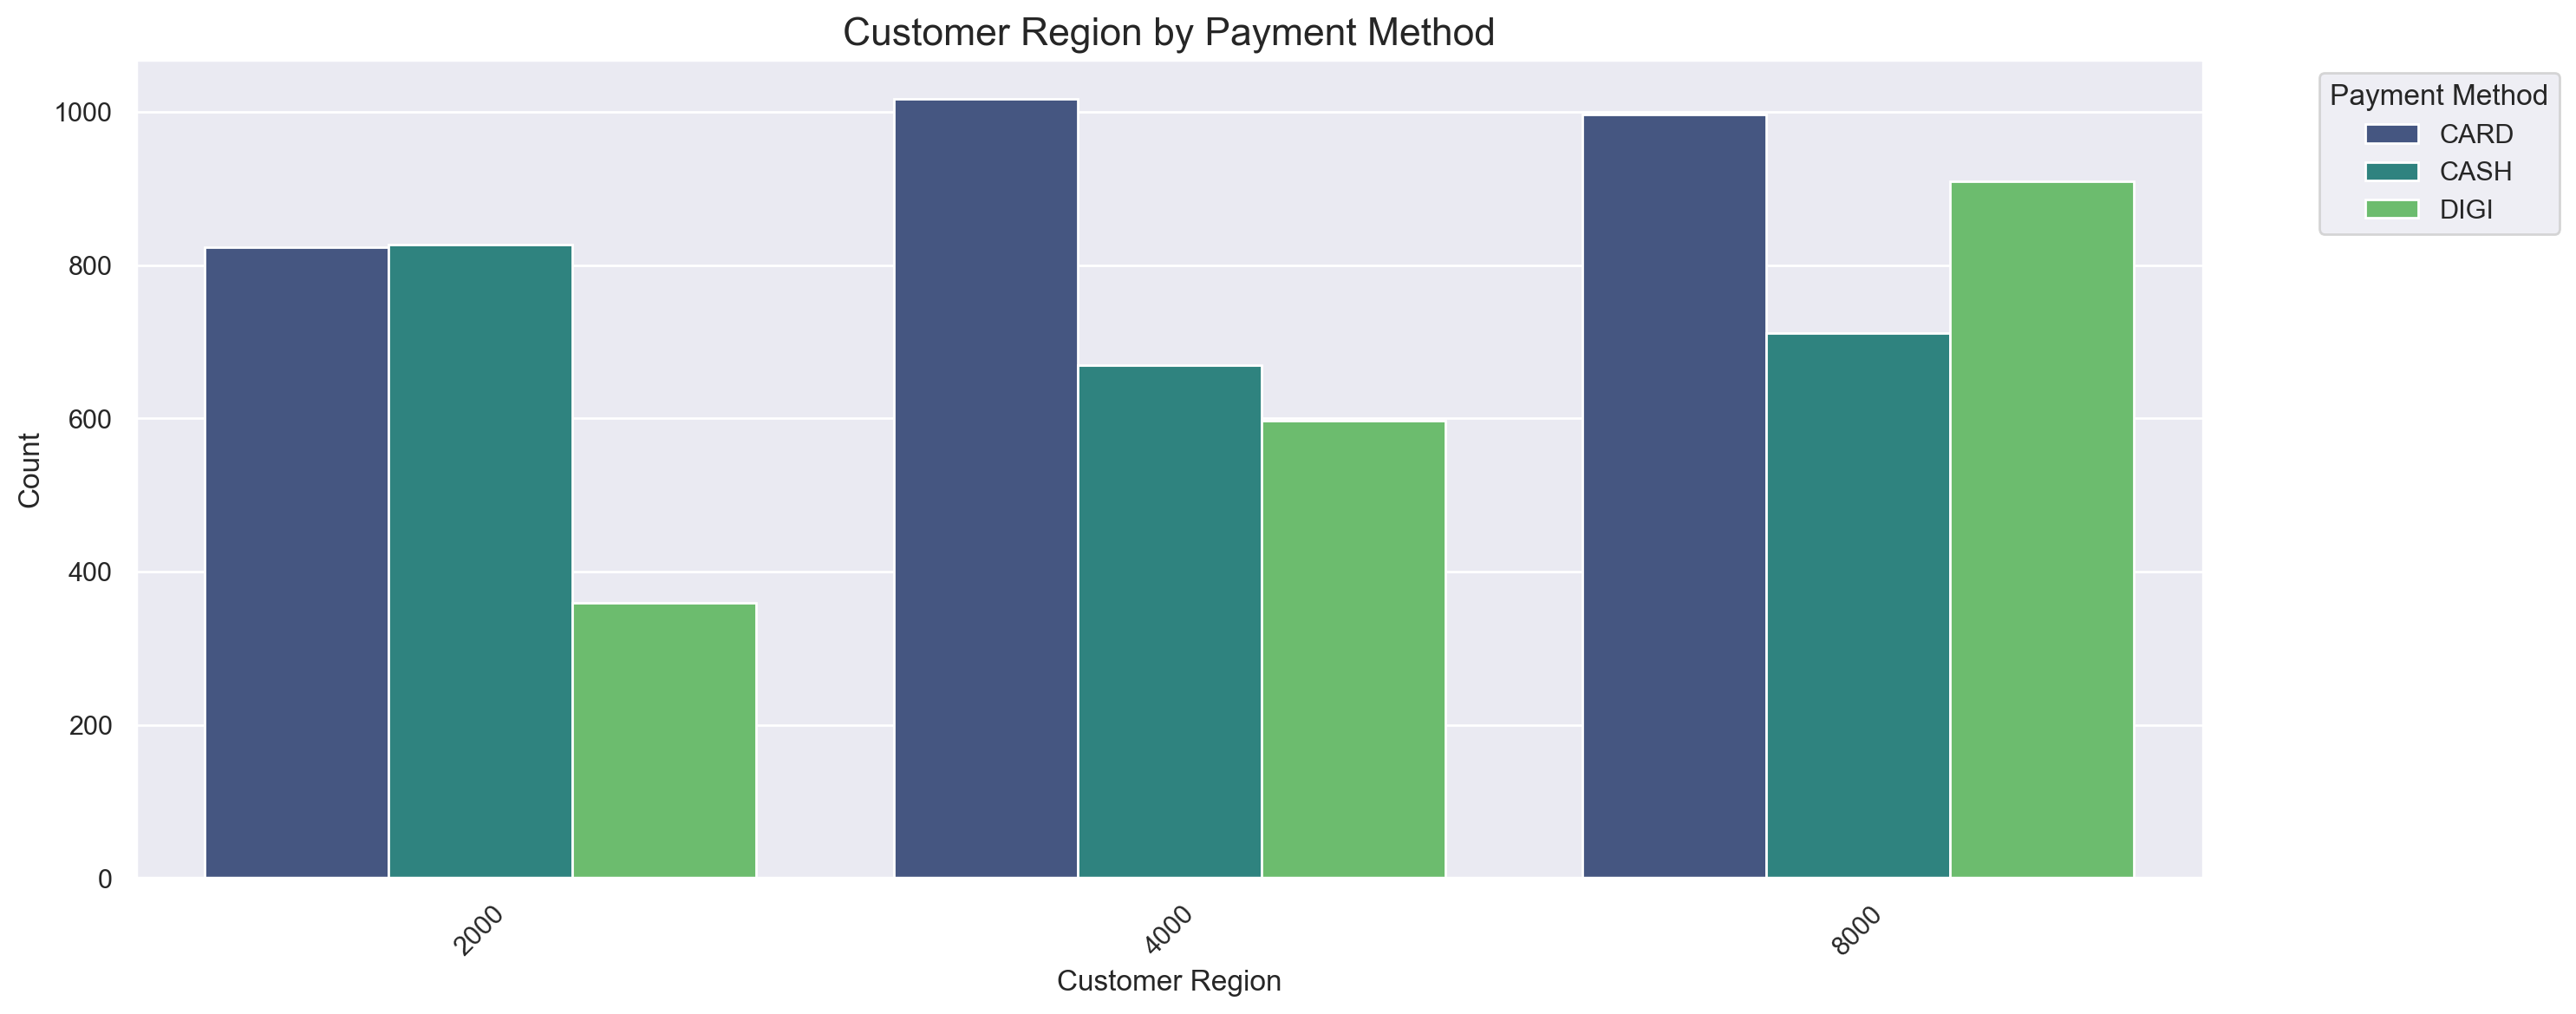

In [54]:
region_payment_data = one_time_customers_df.groupby(['customer_region', 'payment_method']).size().reset_index(name='count')

# Plot the data using a barplot
plt.figure(figsize=(15, 6))
sns.barplot(
    x='customer_region',
    y='count',
    hue='payment_method',
    data=region_payment_data,
    palette='viridis'
)

plt.title('Customer Region by Payment Method', fontsize=16)
plt.xlabel('Customer Region', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- CARD payment method maintains as the highest in all 3 regions, but as DIGI method is the lowest in region 2000, it is also the second highest in the 8000 region.

#### Customer Region vs last promo

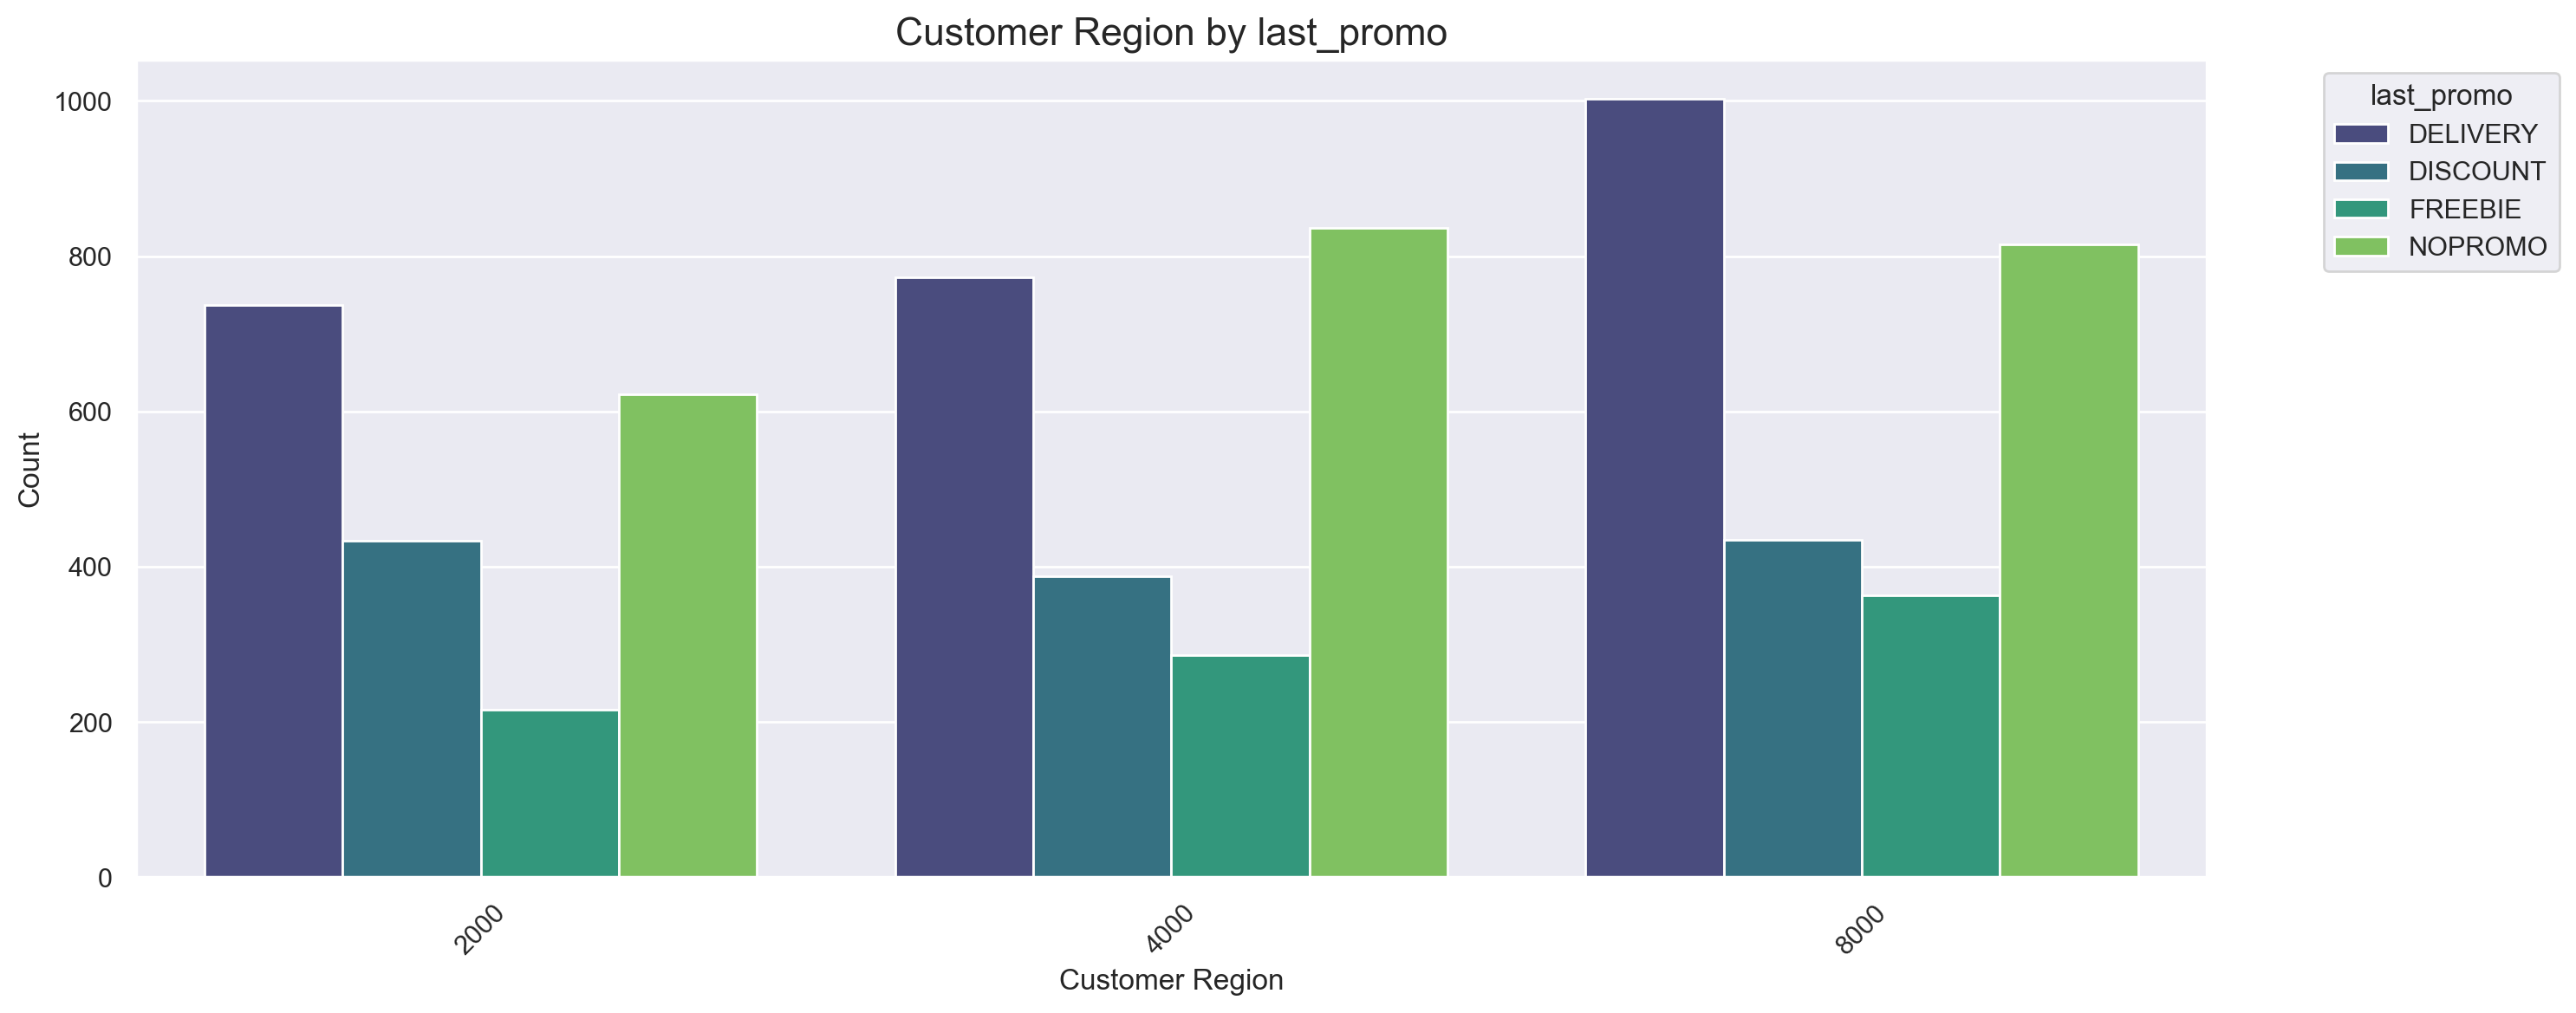

In [55]:
region_payment_data = one_time_customers_df.groupby(['customer_region', 'last_promo']).size().reset_index(name='count')

# Plot the data using a barplot
plt.figure(figsize=(15, 6))
sns.barplot(
    x='customer_region',
    y='count',
    hue='last_promo',
    data=region_payment_data,
    palette='viridis'
)

plt.title('Customer Region by last_promo', fontsize=16)
plt.xlabel('Customer Region', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='last_promo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The distribution of promotino types across the regions, seem to be very similar, except for region 4000 that has NOPROMO type, slightly higher in that region.

#### last promo vs payment method

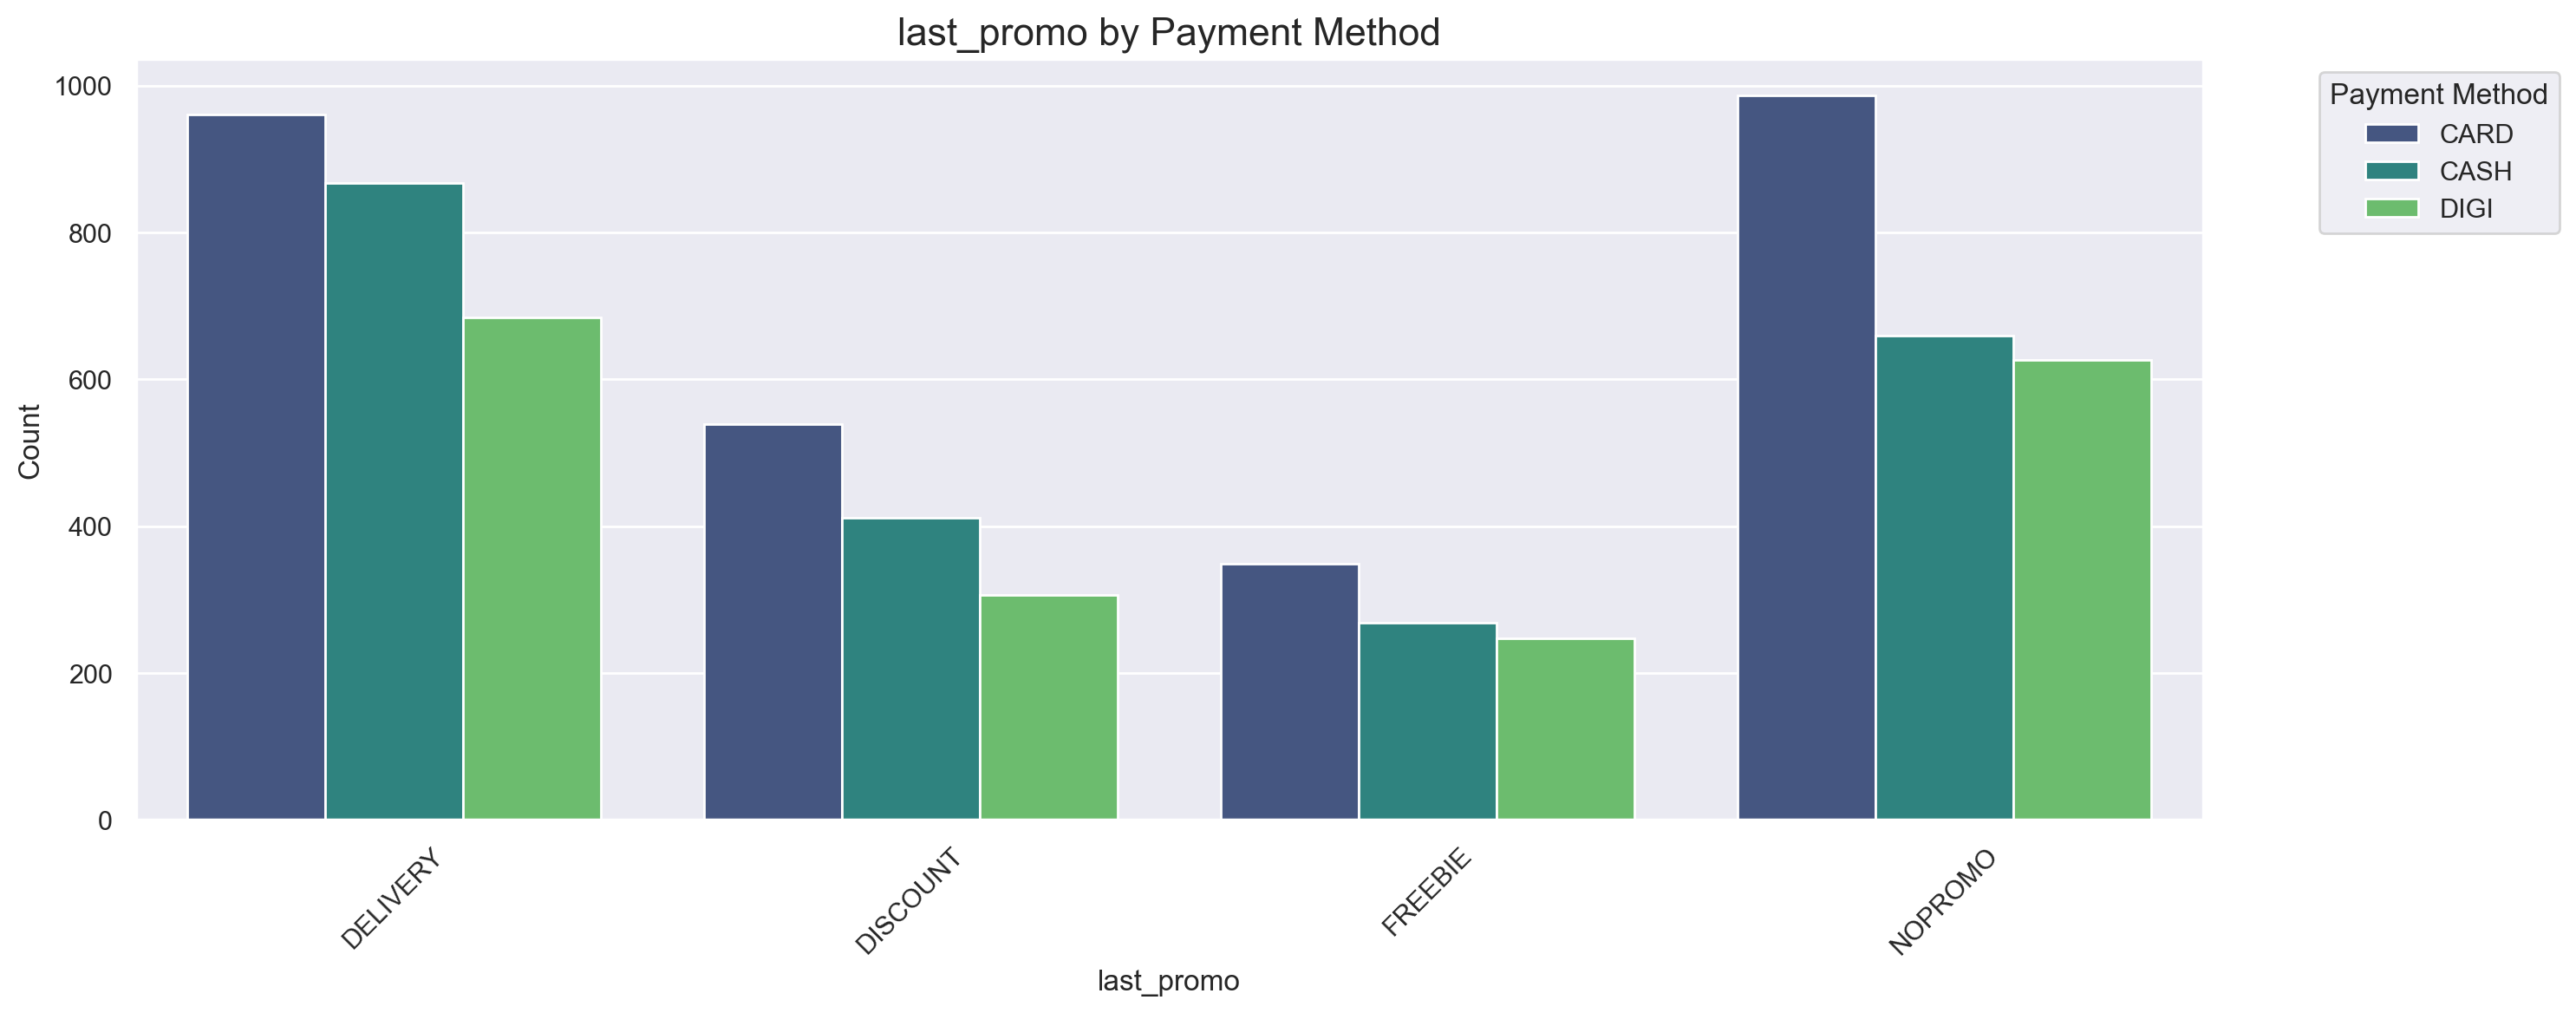

In [56]:
region_payment_data = one_time_customers_df.groupby(['last_promo', 'payment_method']).size().reset_index(name='count')

# Plot the data using a barplot
plt.figure(figsize=(15, 6))
sns.barplot(
    x='last_promo',
    y='count',
    hue='payment_method',
    data=region_payment_data,
    palette='viridis'
)

plt.title('last_promo by Payment Method', fontsize=16)
plt.xlabel('last_promo', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There is no apparent difference in the distribution of payment mehtod per Promotion type.

__**Checking Box Plots**__

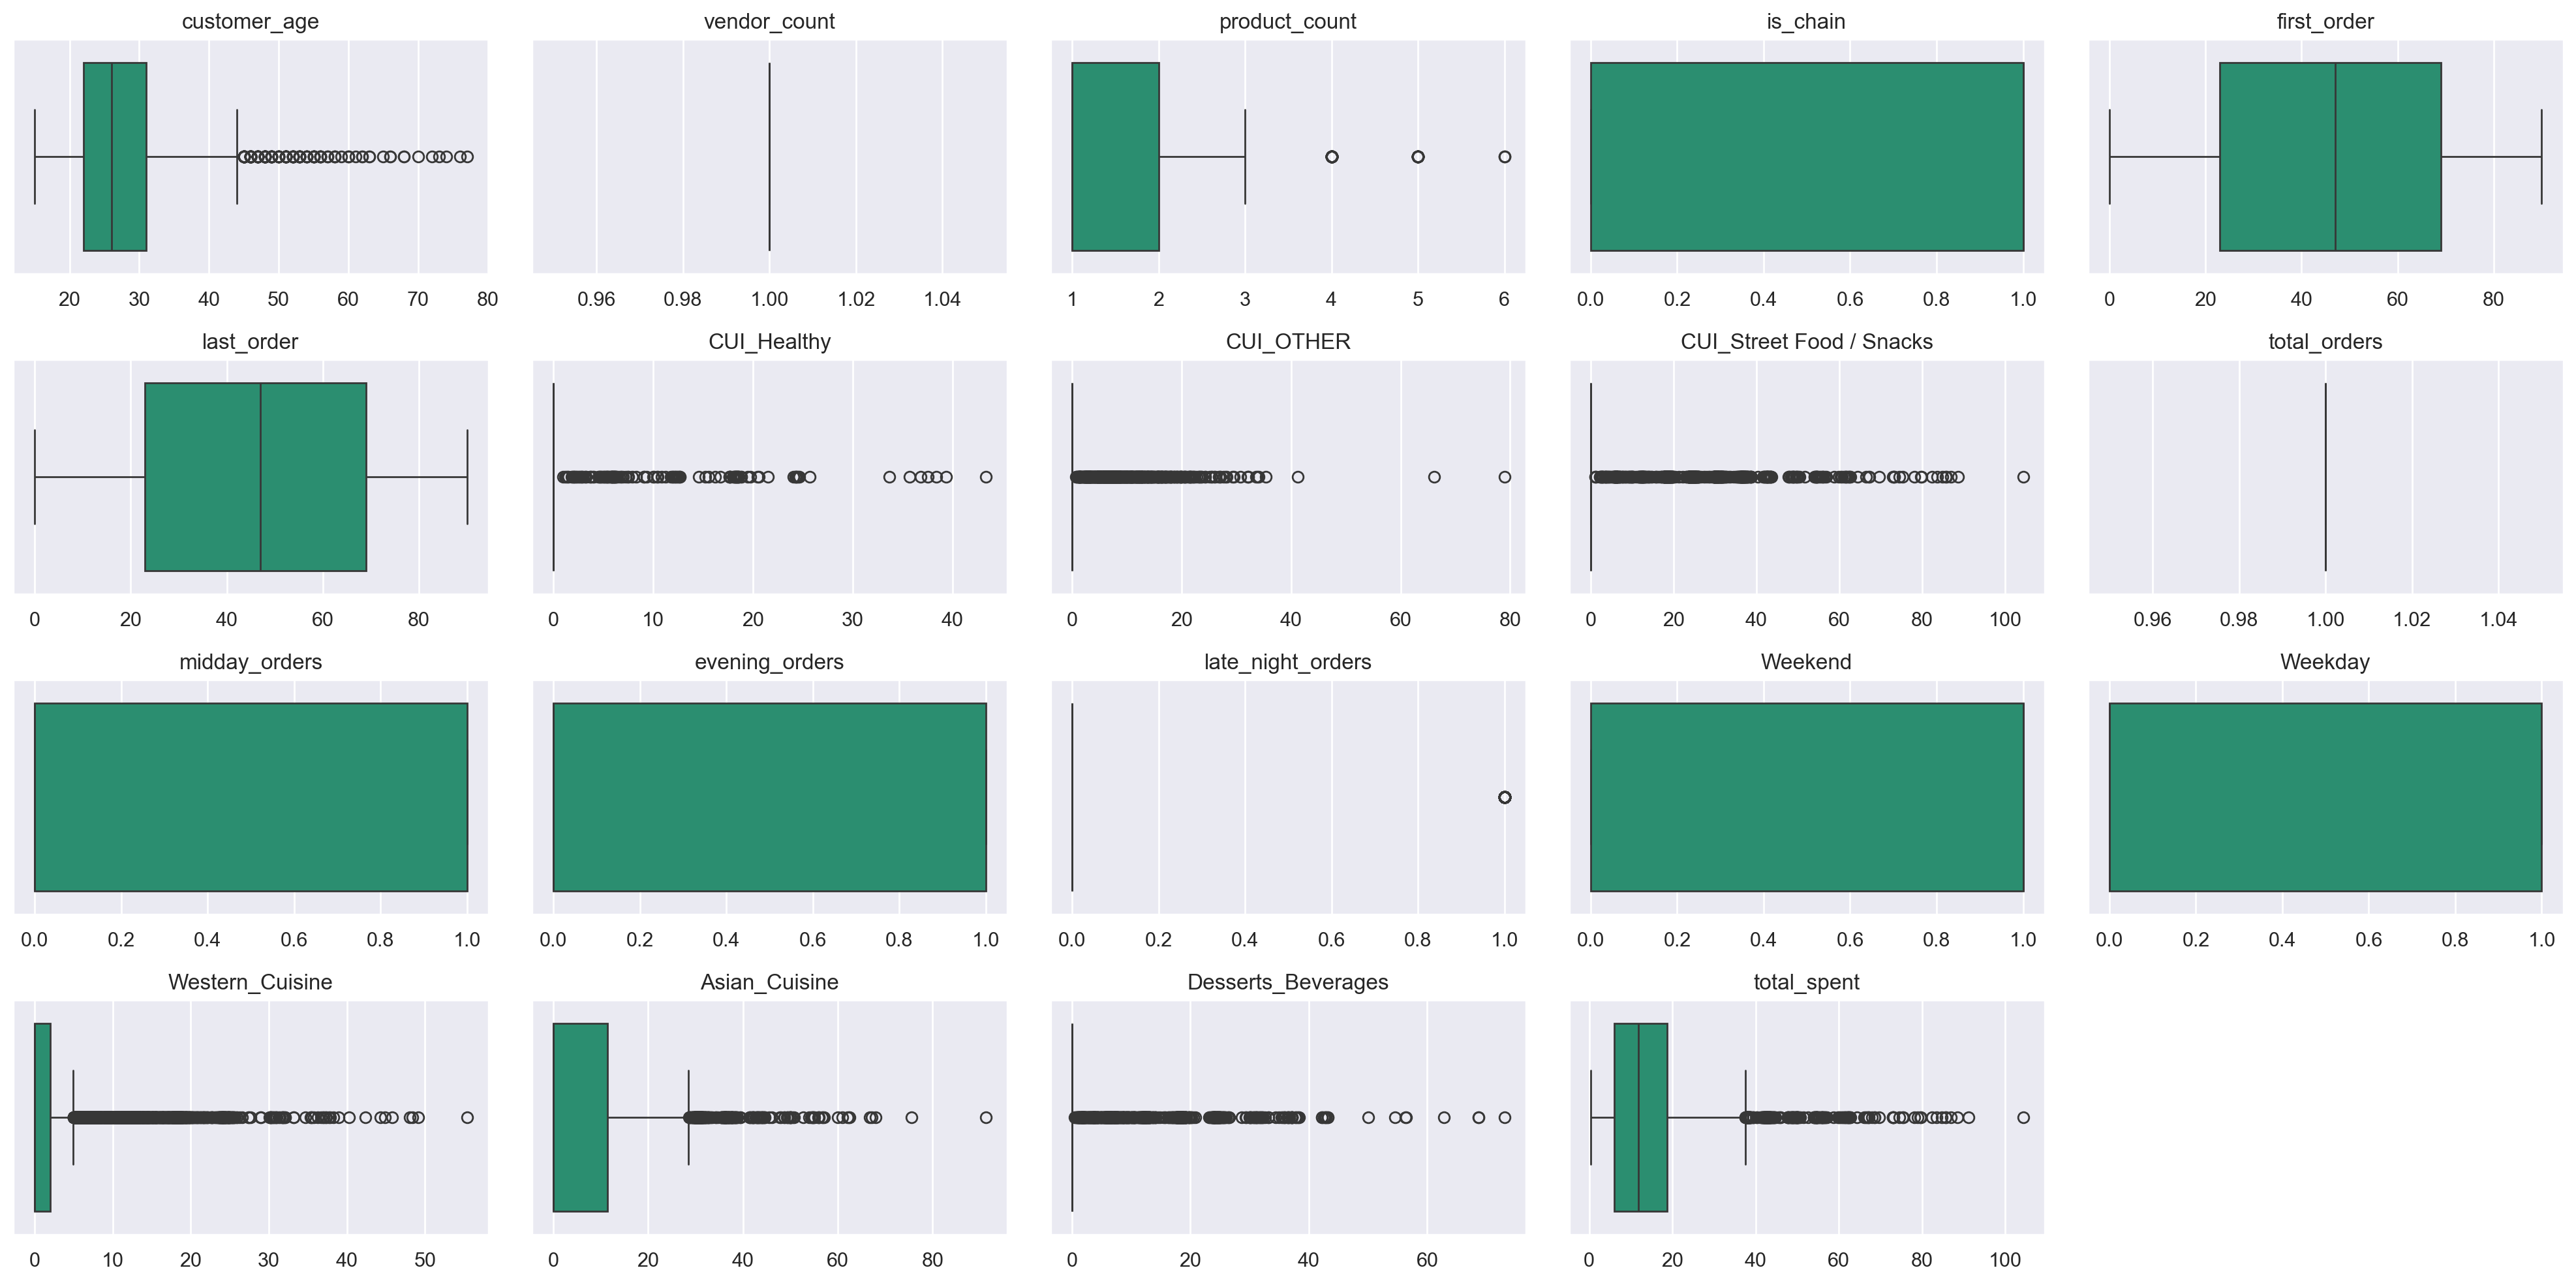

In [20]:
def plot_horizontal_boxplots(data, columns):
    """
    Generate horizontal box plots for each variable in the provided list of columns.
    The plots are arranged in 2 rows and 9 columns.
    
    Parameters:
    - data: DataFrame containing the data.
    - columns: List of column names to plot.
    """
    ncols = 5  # Number of plots per row
    nrows = 4  # Fixed to 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for idx, col in enumerate(columns):
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
                
        # Plot horizontal boxplot
        sns.boxplot(data=data, x=col, ax=axes[idx], palette="Dark2", orient="h")
        axes[idx].set_title(f"{col}")
        axes[idx].set_xlabel("")
    
    # Hide unused subplots if any
    for ax in axes[len(columns):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage example
plot_horizontal_boxplots(data=one_time_customers_df, columns=numerical_columns)

We can observe the presence of some outliers in the one-time cusotmers dataset. Although they are little to non-existent in some columns, som cuisnes columns show some extreme outliers. 

To identify the outiers of the columns, we will use the interquartile range formula, and then get the percentage for eeach column.

In [21]:
outlier_percentages = {}

# We know that low outliers are below Q 1 − 1.5 ⋅ IQR ‍ and high outliers are above Q 3 + 1.5 ⋅ IQR 
for column in numerical_columns:
        #Defining Q1 and Q3 to then find IQR 
        Q1 = one_time_customers_df[column].quantile(0.25)
        Q3 = one_time_customers_df[column].quantile(0.75)
        IQR = Q3 - Q1
        #Getting the outliers below the first quantile and above the second quantile
        outliers = one_time_customers_df[(one_time_customers_df[column] < (Q1 - 1.5 * IQR)) | (one_time_customers_df[column] > (Q3 + 1.5 * IQR))]
        #Getting the percentage of the outliers
        percentage_outliers = (len(outliers) / len(one_time_customers_df)) * 100
        outlier_percentages[column] = percentage_outliers

print("Percentage of outliers per column using IQR:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: \033[1;35m{percentage:.2f}%\033[0m")


Percentage of outliers per column using IQR:
customer_age: 2.88%
vendor_count: 0.00%
product_count: 1.06%
is_chain: 0.00%
first_order: 0.00%
last_order: 0.00%
CUI_Healthy: 2.08%
CUI_OTHER: 8.80%
CUI_Street Food / Snacks: 8.58%
total_orders: 0.00%
midday_orders: 0.00%
evening_orders: 0.00%
late_night_orders: 17.96%
Weekend: 0.00%
Weekday: 0.00%
Western_Cuisine: 20.56%
Asian_Cuisine: 4.23%
Desserts_Beverages: 10.86%
total_spent: 3.46%


As observed, out of the idenfied outliers, only the late night orders column and the columns Desserts_Beverages, Western_Cuisine, and CUI_Street Food/Snacks, present more than 5% of outliers.